# Predicting the 2024 UEFA Euro Using Poisson Distribution

Football predictions have always been a fascinating topic for data scientists and enthusiasts alike. In this project, we leverage the power of the Poisson distribution to forecast the outcomes of the 2024 UEFA European Championship. This method is particularly well-suited for predicting football scores due to the nature of the game, where goals are relatively rare events.

In [1]:
#intalling the necesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.colors as mcolors
import warnings
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

# Data Collection
The first step in our analysis involved gathering historical match data. The dataset sourced from Kaggle contains the results of international football matches starting from the very first official match in 1872 up to 2024.

In [2]:
#Reading the 
df = pd.read_csv('results.csv',sep=',',)
#Dropping matches without final result
df=df[~df['home_score'].isna()]

# ELO Ranking System

The Elo ranking system is a method for calculating the relative skill levels of teams. It is useful for ranking teams based on their performance in previous matches. The Elo rating is dynamic, meaning it changes based on the results of matches, rewarding teams for wins and penalizing them for losses, while also considering the strength of the opponents.

To create our dataset, we need to define some parameters, such as the importance of each tournament in the points exchanged by the Elo ranking system.

In [3]:
#Auxiliary funtions for update the ratings
confederation_tournaments=['AFC Asian Cup','African Cup of Nations','UEFA Euro','Copa América','CONCACAF Championship','Oceania Nations Cup']
confederation_clasification=['UEFA Euro qualification','African Cup of Nations qualification','FC Asian Cup qualification','UEFA Nations League']
def k_value(tournament):
    k=5
    if tournament == 'Friendly':
        k=10
    elif tournament in confederation_clasification:
        k=20
    elif tournament == 'FIFA World Cup qualification':
        k=25
    elif tournament in confederation_tournaments:
        k=40
    elif tournament == 'FIFA World Cup':
        k=50
    return k

def expected_result(loc,aw):
    dr=loc-aw
    we=(1/(10**(-dr/400)+1))
    return [np.round(we,3),1-np.round(we,3)]

def actual_result(loc,aw):
    if loc<aw:
        wa=1
        wl=0
    elif loc>aw:
        wa=0
        wl=1
    elif loc==aw:
        wa=0.5
        wl=0.5
    return [wl,wa]

def calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament):

    k=k_value(tournament)
    wl,wv=actual_result(local_goals,away_goals)
    wel,wev=expected_result(elo_l,elo_v)

    elo_ln=elo_l+k*(wl-wel)
    elo_vn=elo_v+k*(wv-wev)

    return elo_ln,elo_vn,wel,wev

In [4]:
#Calculating the elo points for all historical internatinal matches
current_elo={}
for idx,row in df.iterrows():

    local=row['home_team']
    away=row['away_team']
    local_goals=row['home_score']
    away_goals=row['away_score']
    tournament = row['tournament']


    if local not in current_elo.keys():
        current_elo[local]=1300

    if away not in current_elo.keys():
        current_elo[away]=1300

    elo_l=current_elo[local]
    elo_v=current_elo[away]
    elo_ln,elo_vn, wel,wev=calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament)

    current_elo[local]=elo_ln
    current_elo[away]=elo_vn

    df.loc[idx,'Elo_h_after']=elo_ln
    df.loc[idx,'Elo_a_after']=elo_vn
    df.loc[idx,'Elo_h_before']=elo_l
    df.loc[idx,'Elo_a_before']=elo_v
    df.loc[idx,'probH']=wel
    df.loc[idx,'probA']=wev

Once we have processed the historical data of international matches, we can calculate the final Elo points for each team. This gives us the current Elo ranking, which reflects the latest performance levels of the teams.

In [5]:
elos=pd.concat([df[['date','home_team','Elo_h_after']].rename(columns={'home_team':'Team','Elo_h_after':'Elo'}),df[['date','away_team','Elo_a_after']].rename(columns={'away_team':'Team','Elo_a_after':'Elo'})])
elos.sort_values(by='date', ascending=False,inplace=True)
elos.drop_duplicates('Team',inplace=True)
elos.sort_values(by='Elo', ascending=False, inplace=True)
elos.reset_index(drop=True, inplace=True)
elos['position']=elos.index+1

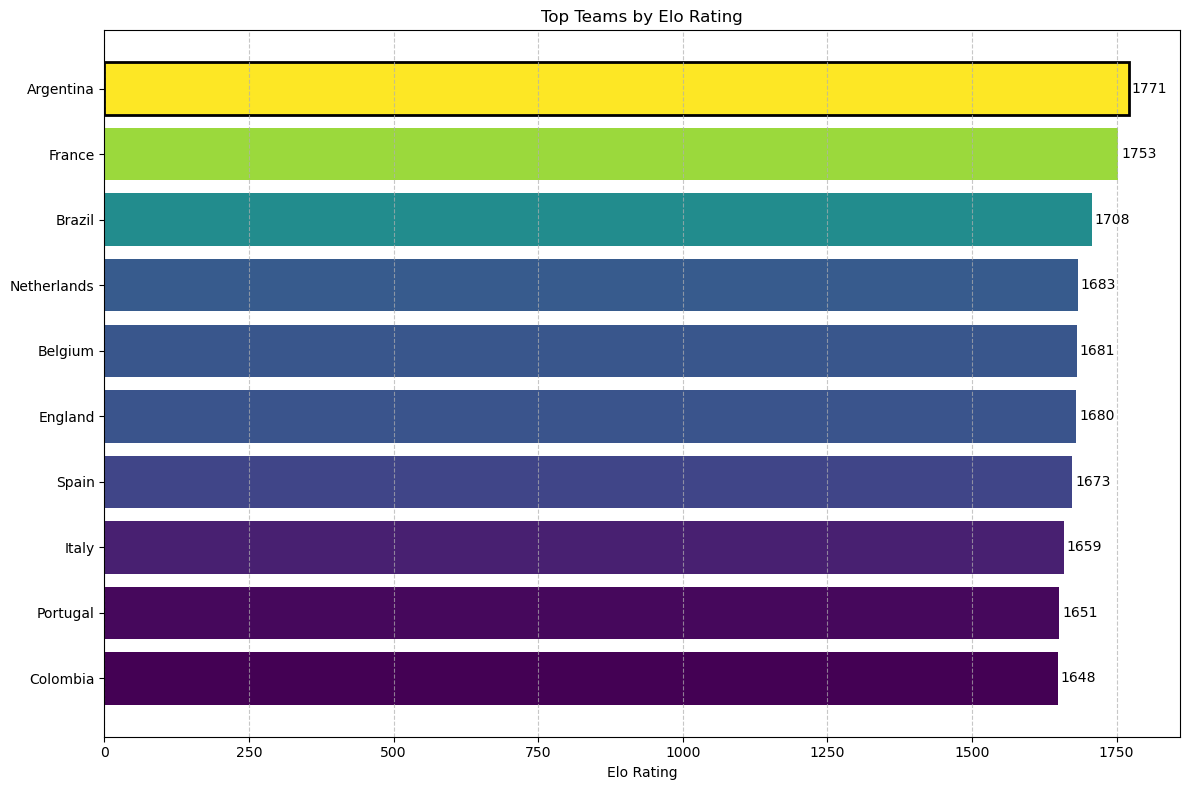

In [6]:
def plot_top_elo(elos, n=10):
    """
    Plots the top n teams by Elo rating in a horizontal bar chart.
    
    Parameters:
    elos (pd.DataFrame): DataFrame containing 'Team' and 'Elo' columns.
    n (int): Number of top teams to display.
    """
    # Sort elos DataFrame by Elo rating in descending order
    elos.sort_values(by='Elo', ascending=False, inplace=True)

    # Select only the top n teams
    top_teams = elos.head(n)

    # Create a color map
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=min(top_teams['Elo']), vmax=max(top_teams['Elo']))
    colors = cmap(norm(top_teams['Elo']))

    # Plotting
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_teams['Team'], top_teams['Elo'], color=colors)
    
    # Add text annotations
    for bar in bars:
        plt.text(
            bar.get_width() + 5, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.0f}', 
            ha='left', 
            va='center',
            fontsize=10
        )

    # Highlighting the top team
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(2)

    # Customizing the plot
    plt.xlabel('Elo Rating')
    plt.title('Top Teams by Elo Rating')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest Elo at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function
plot_top_elo(elos, 10)


We will focus only on the teams participating in the 2024 Euro. Therefore, the ranking would be as follows:

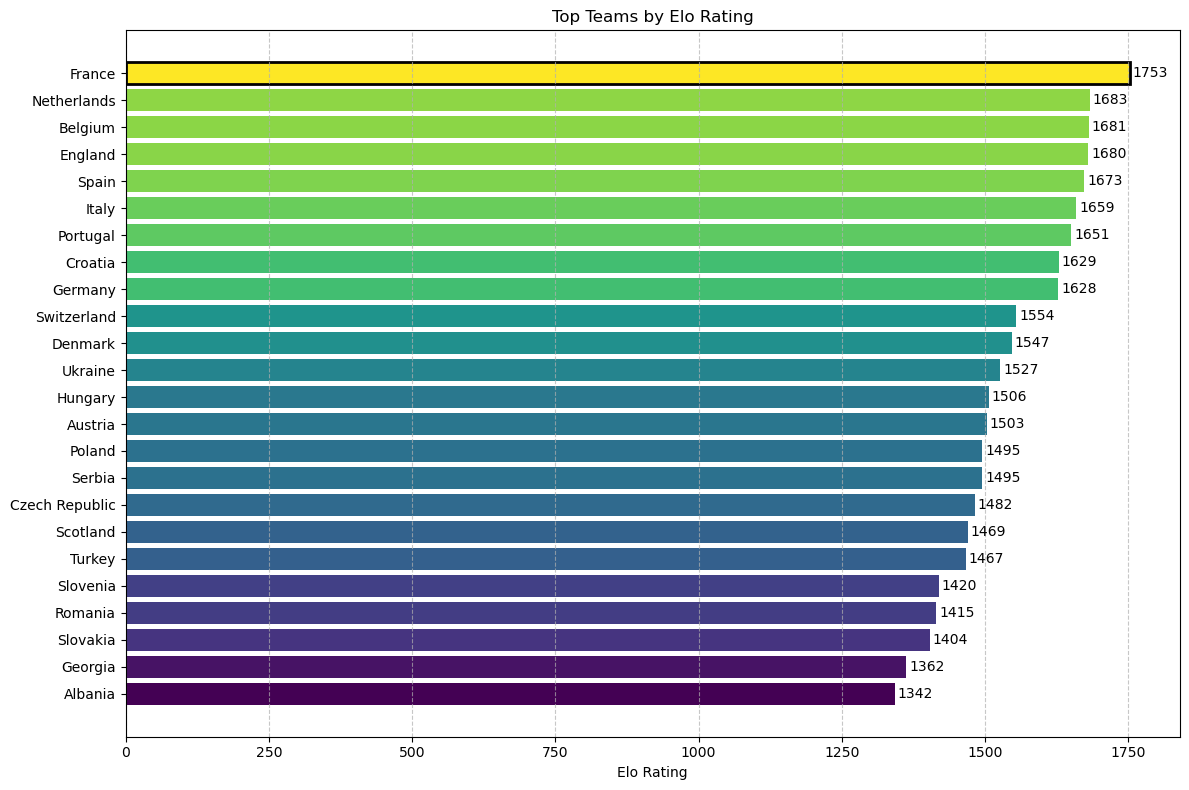

In [7]:
eurocup_teams =[
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

elos_ranking_euro = elos[elos.Team.isin(eurocup_teams)].copy()
plot_top_elo(elos_ranking_euro,24)

Based on this ranking, we can say that France is the favorite to win the Euro, while Albania is the weakest team in the tournament.

One of the problems with international matches is that we don't have the statistics of a league, making it difficult to determine which team has a better attack because it depends on the quality of the opponent. To solve this, and using the same idea as the Elo ranking system above, we can create a ranking for attacking power and defensive power.

In [8]:
elos_ranking_euro

date            Team       Elo  position
1   2024-06-09          France  1752.570         2
3   2024-06-10     Netherlands  1683.040         4
4   2024-06-08         Belgium  1681.085         5
5   2024-06-07         England  1680.295         6
6   2024-06-08           Spain  1673.275         7
7   2024-06-09           Italy  1658.860         8
8   2024-06-11        Portugal  1650.725         9
11  2024-06-08         Croatia  1628.730        12
12  2024-06-07         Germany  1627.950        13
18  2024-06-08     Switzerland  1554.315        19
22  2024-06-08         Denmark  1546.950        23
24  2024-06-11         Ukraine  1526.900        25
28  2024-06-08         Hungary  1506.305        29
29  2024-06-08         Austria  1503.390        30
30  2024-06-10          Poland  1495.190        31
31  2024-06-08          Serbia  1495.055        32
37  2024-06-10  Czech Republic  1482.325        38
41  2024-06-07        Scotland  1469.430        42
42  2024-06-10          Turkey  1466.605        43
63  2024-06-08        Slovenia  1419.585        64
64  2024-06-07         Romania  1414.880        65
66  2024-06-09        Slovakia  1403.825        67
78  2024-06-09         Georgia  1362.370        79
83  2024-06-07         Albania  1342.140        84

In [9]:
def calculate_attdef(Attack_l,Attack_v,Deffend_l,Deffend_v,localGoals,awayGoals, tournament,neutral):
    k=k_value(tournament)
    if neutral==False:
        c=1.27
    else:
        c=1
    ehg=Attack_l*Deffend_v*c
    eag=Attack_v*Deffend_l/c
    Attack_ln=Attack_l+(k/2000)*(localGoals-ehg)
    Attack_vn=Attack_v+(k/2000)*(awayGoals-eag)
    Deffend_ln=Deffend_l+(k/2000)*(awayGoals-eag)
    Deffend_vn=Deffend_v+(k/2000)*(localGoals-ehg)
  
    return Attack_ln,Attack_vn,Deffend_ln,Deffend_vn, ehg, eag

In [10]:
current_att={}
current_def={}
for idx,row in df.iterrows():

    local=row['home_team']
    away=row['away_team']
    local_goals=row['home_score']
    away_goals=row['away_score']
    tournament=row['tournament']
    neutral=row['neutral']

    if local not in current_att.keys():
        current_att[local]=1.3
    if away not in current_att.keys():
        current_att[away]=1.3
    if local not in current_def.keys():
        current_def[local]=1.3
    if away not in current_def.keys():
        current_def[away]=1.3

    att_l=current_att[local]
    att_v=current_att[away]
    def_l=current_def[local]
    def_v=current_def[away]

    att_ln,att_vn, def_ln, def_vn, ehg, eag=calculate_attdef(att_l,att_v,def_l,def_v,local_goals,away_goals, tournament,neutral)

    current_att[local]=att_ln
    current_att[away]=att_vn
    current_def[local]=def_ln
    current_def[away]=def_vn

    df.loc[idx,'att_h_after']=att_ln
    df.loc[idx,'att_a_after']=att_vn
    df.loc[idx,'att_h_before']=att_l
    df.loc[idx,'att_a_before']=att_v
    df.loc[idx,'def_h_after']=def_ln
    df.loc[idx,'def_a_after']=def_vn
    df.loc[idx,'def_h_before']=def_l
    df.loc[idx,'def_a_before']=def_v
    df.loc[idx,'XGhome']=ehg
    df.loc[idx,'XGaway']=eag

In [11]:
attdef=df.copy()
attdef=pd.concat([df[['date','home_team','att_h_after','def_h_after']].rename(columns={'home_team':'Team','att_h_after':'att','def_h_after':'def'}),df[['date','away_team','att_a_after','def_a_after']].rename(columns={'away_team':'Team','att_a_after':'att','def_a_after':'def'})])
attdef.sort_values(by='date', ascending=False,inplace=True)
attdef.drop_duplicates('Team',inplace=True)
attdef.sort_values(by='def', ascending=True,inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['def_position']=attdef.index+1
attdef.sort_values(by='att', ascending=False,inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['att_position']=attdef.index+1

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_att_def(elos, n=10):
    """
    Plot the top teams by attacking and defensive power.

    Parameters:
    elos (pd.DataFrame): DataFrame containing team ratings.
    n (int): Number of top teams to display.
    """
    # Sort elos DataFrame by attacking and defensive ratings
    elos_sorted_att = elos.sort_values(by='att', ascending=False).head(n)
    elos_sorted_def = elos.sort_values(by='def', ascending=True).head(n)

    # Create a color map for both plots
    colors_att = plt.cm.viridis(elos_sorted_att['att'] / max(elos_sorted_att['att']))
    colors_def = plt.cm.viridis(elos_sorted_def['def'] / max(elos_sorted_def['def']))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for attacking ratings
    bars_att = ax1.barh(elos_sorted_att['Team'], elos_sorted_att['att'], color=colors_att)
    ax1.set_xlabel('Attacking Power', fontsize=14)
    ax1.set_title('Top Teams by Attacking Power', fontsize=16, weight='bold')
    ax1.invert_yaxis()  # Invert y-axis to display the highest rating at the top
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for attacking ratings
    for bar in bars_att:
        ax1.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Plot for defensive ratings
    bars_def = ax2.barh(elos_sorted_def['Team'], elos_sorted_def['def'], color=colors_def)
    ax2.set_xlabel('Defensive Power', fontsize=14)
    ax2.set_title('Top Teams by Defensive Power', fontsize=16, weight='bold')
    ax2.invert_yaxis()  # Invert y-axis to display the highest rating at the top
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for defensive ratings
    for bar in bars_def:
        ax2.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


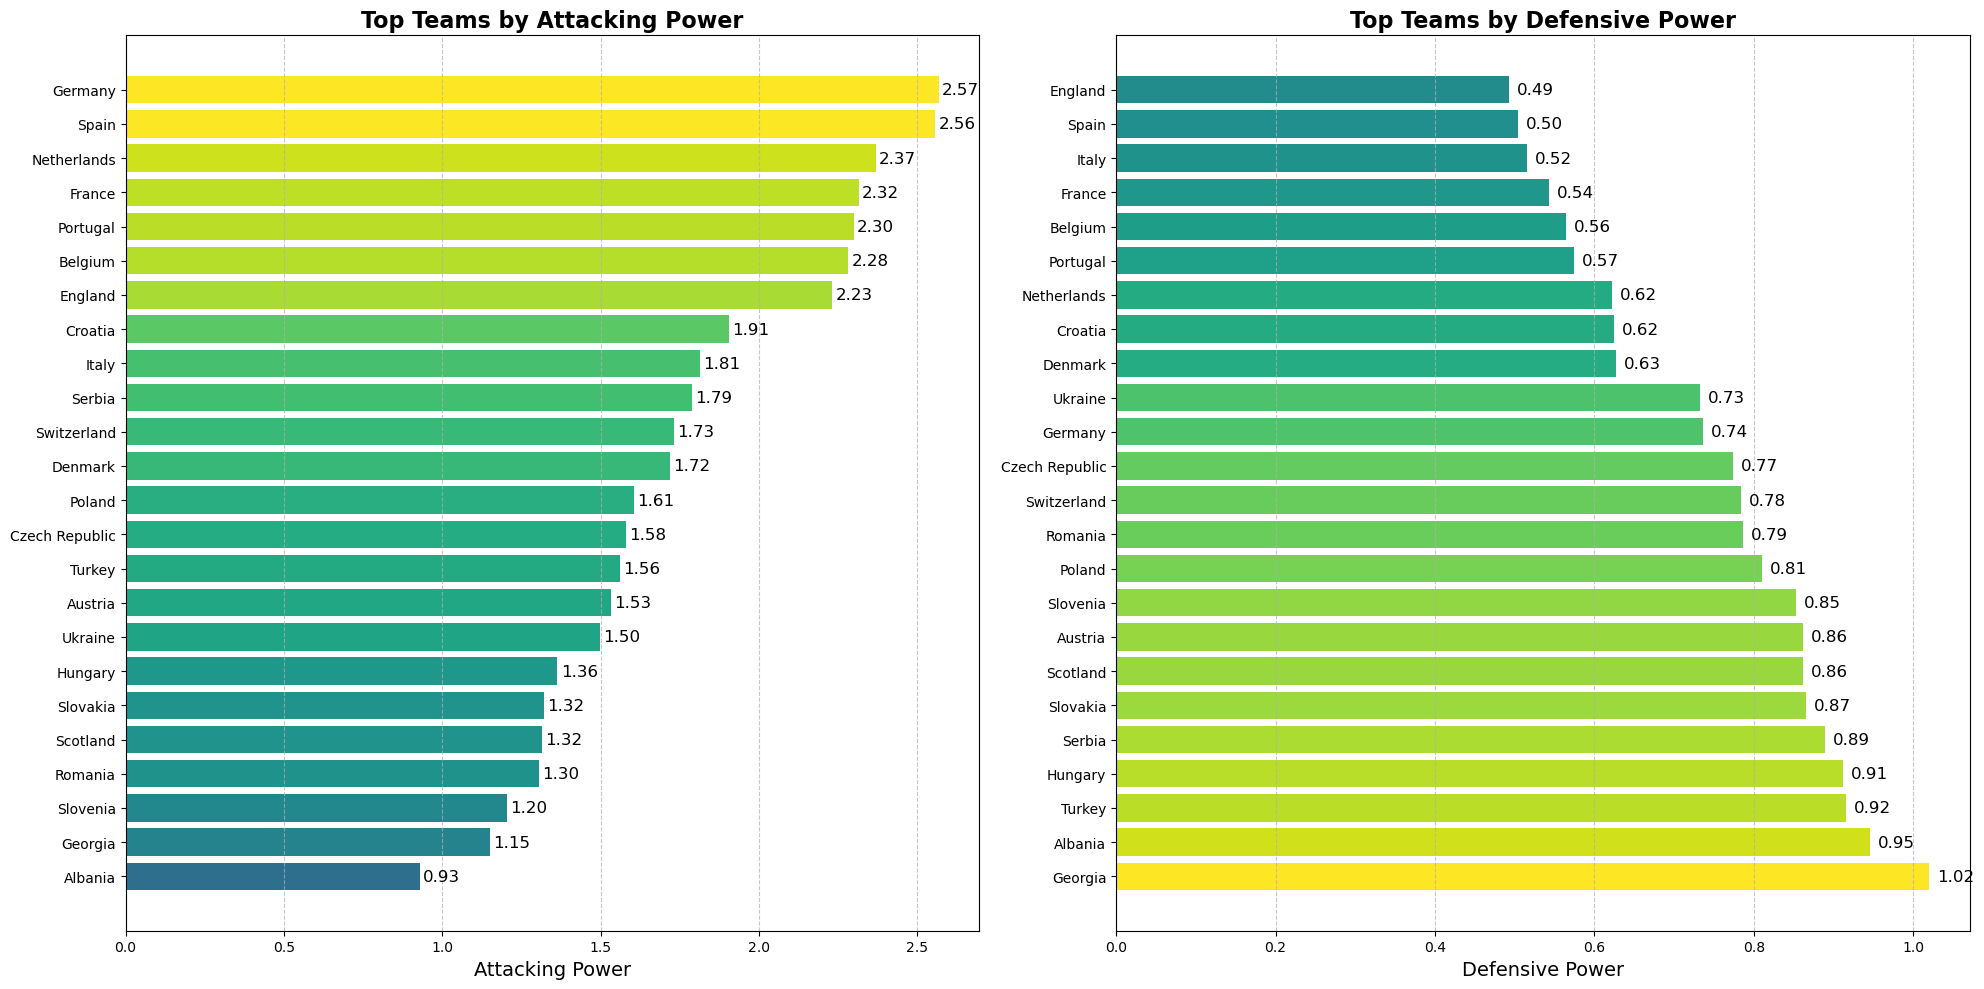

In [13]:
attdef_ranking_europe = attdef[attdef.Team.isin(eurocup_teams)]
plot_top_att_def(attdef_ranking_europe,24)

In [14]:
attdef_ranking_europe

date            Team       att       def  def_position  \
0    2024-06-07         Germany  2.568137  0.736362            39   
1    2024-06-08           Spain  2.556965  0.504760             5   
3    2024-06-10     Netherlands  2.370050  0.622326            17   
4    2024-06-09          France  2.316062  0.543255             9   
5    2024-06-11        Portugal  2.299713  0.574171            12   
6    2024-06-08         Belgium  2.282870  0.564715            11   
9    2024-06-07         England  2.232232  0.492452             4   
12   2024-06-08         Croatia  1.906891  0.624911            18   
14   2024-06-09           Italy  1.812726  0.515376             6   
16   2024-06-08          Serbia  1.789521  0.889672            74   
19   2024-06-08     Switzerland  1.731058  0.783603            46   
20   2024-06-08         Denmark  1.720159  0.626862            19   
33   2024-06-10          Poland  1.607147  0.810224            54   
34   2024-06-10  Czech Republic  1.581925  0.773698            45   
38   2024-06-10          Turkey  1.561179  0.915570            77   
44   2024-06-08         Austria  1.534476  0.861345            67   
47   2024-06-11         Ukraine  1.498727  0.732182            37   
70   2024-06-08         Hungary  1.364134  0.911723            76   
94   2024-06-09        Slovakia  1.322737  0.865465            69   
105  2024-06-07        Scotland  1.315495  0.861902            68   
121  2024-06-07         Romania  1.304309  0.786796            47   
207  2024-06-08        Slovenia  1.203744  0.852783            64   
226  2024-06-09         Georgia  1.149717  1.020186            92   
282  2024-06-07         Albania  0.929605  0.945796            82   

     att_position  
0               1  
1               2  
3               4  
4               5  
5               6  
6               7  
9              10  
12             13  
14             15  
16             17  
19             20  
20             21  
33             34  
34             35  
38             39  
44             45  
47             48  
70             71  
94             95  
105           106  
121           122  
207           208  
226           227  
282           283

Based on this ranking, we can conclude that the teams with the best attack are Germany and Spain. The teams with the best defense are England, Spain, and Italy.

# Goals Expected and Poisson Distribution

The best aspect of this ranking is that we can use it to calculate the expected goals in a match. The expected goals for a team can be calculated as:

$$
Expected Goals=
Attacking Power Team×Defensive Power Opponent$$

Additionally, in non-neutral matches, we have to set a parameter for the advantage of the home team. This parameter adjusts the expected goals to account for the home field advantage.

Let see if the results adjust with Expected goals we predicted, for doing that we consider the results of European tournaments of the last 14 years.

In [15]:
#Creating the reference dataset
df2 = df[(df.date>"2010-09-01") & (df.tournament.isin(["UEFA Euro","UEFA Euro qualification","UEFA Nations League"]))].copy()

# Define the bins
bins = np.array([1.5,2.25, 2.5, 2.75, 3,10])  # adjust this to fit your data
df2['total_score'] = df2['away_score'] + df2['home_score']
df2['total_xG']=df2['XGhome']+df2['XGaway']
df2['total_xG_bin'] = pd.cut(df2['total_xG'], bins)

# Group by the bin and calculate the mean of the 'Goals' column
binned_means = df2.groupby('total_xG_bin')['total_score'].agg(["mean","count"])

print(binned_means)

                  mean  count
total_xG_bin                 
(1.5, 2.25]   2.249307    361
(2.25, 2.5]   2.381963    377
(2.5, 2.75]   2.536657    341
(2.75, 3.0]   2.944186    215
(3.0, 10.0]   3.509146    328


In [16]:
df2

date               home_team               away_team  home_score  \
33959  2010-09-02                  Israel                   Malta         3.0   
33961  2010-09-03                 Andorra                  Russia         0.0   
33962  2010-09-03                 Armenia     Republic of Ireland         0.0   
33963  2010-09-03                 Belgium                 Germany         0.0   
33965  2010-09-03                 England                Bulgaria         4.0   
33966  2010-09-03                 Estonia                   Italy         1.0   
33967  2010-09-03           Faroe Islands                  Serbia         0.0   
33968  2010-09-03                  France                 Belarus         0.0   
33969  2010-09-03                  Greece                 Georgia         1.0   
33970  2010-09-03                 Iceland                  Norway         1.0   
33971  2010-09-03              Kazakhstan                  Turkey         0.0   
33973  2010-09-03                  Latvia                 Croatia         0.0   
33974  2010-09-03           Liechtenstein                   Spain         0.0   
33975  2010-09-03               Lithuania                Scotland         0.0   
33976  2010-09-03              Luxembourg  Bosnia and Herzegovina         0.0   
33977  2010-09-03                 Moldova                 Finland         2.0   
33978  2010-09-03              Montenegro                   Wales         1.0   
33981  2010-09-03                Portugal                  Cyprus         4.0   
33983  2010-09-03                 Romania                 Albania         1.0   
33984  2010-09-03              San Marino             Netherlands         0.0   
33985  2010-09-03                Slovakia         North Macedonia         1.0   
33986  2010-09-03                Slovenia        Northern Ireland         0.0   
33987  2010-09-03                  Sweden                 Hungary         2.0   
34019  2010-09-07                 Albania              Luxembourg         1.0   
34021  2010-09-07                 Austria              Kazakhstan         2.0   
34023  2010-09-07                 Belarus                 Romania         0.0   
34024  2010-09-07  Bosnia and Herzegovina                  France         0.0   
34025  2010-09-07                Bulgaria              Montenegro         0.0   
34028  2010-09-07                 Croatia                  Greece         0.0   
34029  2010-09-07          Czech Republic               Lithuania         0.0   
34030  2010-09-07                 Denmark                 Iceland         1.0   
34033  2010-09-07                 Georgia                  Israel         0.0   
34034  2010-09-07                 Germany              Azerbaijan         6.0   
34035  2010-09-07                 Hungary                 Moldova         2.0   
34036  2010-09-07     Republic of Ireland                 Andorra         3.0   
34037  2010-09-07                   Italy           Faroe Islands         5.0   
34041  2010-09-07         North Macedonia                 Armenia         2.0   
34042  2010-09-07                   Malta                  Latvia         0.0   
34044  2010-09-07             Netherlands                 Finland         2.0   
34045  2010-09-07                  Norway                Portugal         1.0   
34049  2010-09-07                  Russia                Slovakia         0.0   
34050  2010-09-07                Scotland           Liechtenstein         2.0   
34051  2010-09-07                  Serbia                Slovenia         1.0   
34052  2010-09-07                  Sweden              San Marino         6.0   
34053  2010-09-07             Switzerland                 England         1.0   
34054  2010-09-07                  Turkey                 Belgium         3.0   
34111  2010-10-08                 Albania  Bosnia and Herzegovina         1.0   
34112  2010-10-08                 Andorra         North Macedonia         0.0   
34113  2010-10-08                 Armenia   

In [17]:
df2.columns


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'Elo_h_after',
       'Elo_a_after', 'Elo_h_before', 'Elo_a_before', 'probH', 'probA',
       'att_h_after', 'att_a_after', 'att_h_before', 'att_a_before',
       'def_h_after', 'def_a_after', 'def_h_before', 'def_a_before', 'XGhome',
       'XGaway', 'total_score', 'total_xG', 'total_xG_bin'],
      dtype='object')

In [18]:
df2['year']=df2['date'].apply(lambda x: int(x[:4]))
df2

date               home_team               away_team  home_score  \
33959  2010-09-02                  Israel                   Malta         3.0   
33961  2010-09-03                 Andorra                  Russia         0.0   
33962  2010-09-03                 Armenia     Republic of Ireland         0.0   
33963  2010-09-03                 Belgium                 Germany         0.0   
33965  2010-09-03                 England                Bulgaria         4.0   
33966  2010-09-03                 Estonia                   Italy         1.0   
33967  2010-09-03           Faroe Islands                  Serbia         0.0   
33968  2010-09-03                  France                 Belarus         0.0   
33969  2010-09-03                  Greece                 Georgia         1.0   
33970  2010-09-03                 Iceland                  Norway         1.0   
33971  2010-09-03              Kazakhstan                  Turkey         0.0   
33973  2010-09-03                  Latvia                 Croatia         0.0   
33974  2010-09-03           Liechtenstein                   Spain         0.0   
33975  2010-09-03               Lithuania                Scotland         0.0   
33976  2010-09-03              Luxembourg  Bosnia and Herzegovina         0.0   
33977  2010-09-03                 Moldova                 Finland         2.0   
33978  2010-09-03              Montenegro                   Wales         1.0   
33981  2010-09-03                Portugal                  Cyprus         4.0   
33983  2010-09-03                 Romania                 Albania         1.0   
33984  2010-09-03              San Marino             Netherlands         0.0   
33985  2010-09-03                Slovakia         North Macedonia         1.0   
33986  2010-09-03                Slovenia        Northern Ireland         0.0   
33987  2010-09-03                  Sweden                 Hungary         2.0   
34019  2010-09-07                 Albania              Luxembourg         1.0   
34021  2010-09-07                 Austria              Kazakhstan         2.0   
34023  2010-09-07                 Belarus                 Romania         0.0   
34024  2010-09-07  Bosnia and Herzegovina                  France         0.0   
34025  2010-09-07                Bulgaria              Montenegro         0.0   
34028  2010-09-07                 Croatia                  Greece         0.0   
34029  2010-09-07          Czech Republic               Lithuania         0.0   
34030  2010-09-07                 Denmark                 Iceland         1.0   
34033  2010-09-07                 Georgia                  Israel         0.0   
34034  2010-09-07                 Germany              Azerbaijan         6.0   
34035  2010-09-07                 Hungary                 Moldova         2.0   
34036  2010-09-07     Republic of Ireland                 Andorra         3.0   
34037  2010-09-07                   Italy           Faroe Islands         5.0   
34041  2010-09-07         North Macedonia                 Armenia         2.0   
34042  2010-09-07                   Malta                  Latvia         0.0   
34044  2010-09-07             Netherlands                 Finland         2.0   
34045  2010-09-07                  Norway                Portugal         1.0   
34049  2010-09-07                  Russia                Slovakia         0.0   
34050  2010-09-07                Scotland           Liechtenstein         2.0   
34051  2010-09-07                  Serbia                Slovenia         1.0   
34052  2010-09-07                  Sweden              San Marino         6.0   
34053  2010-09-07             Switzerland                 England         1.0   
34054  2010-09-07                  Turkey                 Belgium         3.0   
34111  2010-10-08                 Albania  Bosnia and Herzegovina         1.0   
34112  2010-10-08                 Andorra         North Macedonia         0.0   
34113  2010-10-08                 Armenia   

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1622 entries, 33959 to 47032
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date          1622 non-null   object  
 1   home_team     1622 non-null   object  
 2   away_team     1622 non-null   object  
 3   home_score    1622 non-null   float64 
 4   away_score    1622 non-null   float64 
 5   tournament    1622 non-null   object  
 6   city          1622 non-null   object  
 7   country       1622 non-null   object  
 8   neutral       1622 non-null   bool    
 9   Elo_h_after   1622 non-null   float64 
 10  Elo_a_after   1622 non-null   float64 
 11  Elo_h_before  1622 non-null   float64 
 12  Elo_a_before  1622 non-null   float64 
 13  probH         1622 non-null   float64 
 14  probA         1622 non-null   float64 
 15  att_h_after   1622 non-null   float64 
 16  att_a_after   1622 non-null   float64 
 17  att_h_before  1622 non-null   float64 
 18  att_a_be

In [20]:
df2['home_diff_elo']=df2['Elo_h_after']-df2['Elo_a_after']
df2['away_diff_elo']=df2['Elo_a_after']-df2['Elo_h_after']
df2

date               home_team               away_team  home_score  \
33959  2010-09-02                  Israel                   Malta         3.0   
33961  2010-09-03                 Andorra                  Russia         0.0   
33962  2010-09-03                 Armenia     Republic of Ireland         0.0   
33963  2010-09-03                 Belgium                 Germany         0.0   
33965  2010-09-03                 England                Bulgaria         4.0   
33966  2010-09-03                 Estonia                   Italy         1.0   
33967  2010-09-03           Faroe Islands                  Serbia         0.0   
33968  2010-09-03                  France                 Belarus         0.0   
33969  2010-09-03                  Greece                 Georgia         1.0   
33970  2010-09-03                 Iceland                  Norway         1.0   
33971  2010-09-03              Kazakhstan                  Turkey         0.0   
33973  2010-09-03                  Latvia                 Croatia         0.0   
33974  2010-09-03           Liechtenstein                   Spain         0.0   
33975  2010-09-03               Lithuania                Scotland         0.0   
33976  2010-09-03              Luxembourg  Bosnia and Herzegovina         0.0   
33977  2010-09-03                 Moldova                 Finland         2.0   
33978  2010-09-03              Montenegro                   Wales         1.0   
33981  2010-09-03                Portugal                  Cyprus         4.0   
33983  2010-09-03                 Romania                 Albania         1.0   
33984  2010-09-03              San Marino             Netherlands         0.0   
33985  2010-09-03                Slovakia         North Macedonia         1.0   
33986  2010-09-03                Slovenia        Northern Ireland         0.0   
33987  2010-09-03                  Sweden                 Hungary         2.0   
34019  2010-09-07                 Albania              Luxembourg         1.0   
34021  2010-09-07                 Austria              Kazakhstan         2.0   
34023  2010-09-07                 Belarus                 Romania         0.0   
34024  2010-09-07  Bosnia and Herzegovina                  France         0.0   
34025  2010-09-07                Bulgaria              Montenegro         0.0   
34028  2010-09-07                 Croatia                  Greece         0.0   
34029  2010-09-07          Czech Republic               Lithuania         0.0   
34030  2010-09-07                 Denmark                 Iceland         1.0   
34033  2010-09-07                 Georgia                  Israel         0.0   
34034  2010-09-07                 Germany              Azerbaijan         6.0   
34035  2010-09-07                 Hungary                 Moldova         2.0   
34036  2010-09-07     Republic of Ireland                 Andorra         3.0   
34037  2010-09-07                   Italy           Faroe Islands         5.0   
34041  2010-09-07         North Macedonia                 Armenia         2.0   
34042  2010-09-07                   Malta                  Latvia         0.0   
34044  2010-09-07             Netherlands                 Finland         2.0   
34045  2010-09-07                  Norway                Portugal         1.0   
34049  2010-09-07                  Russia                Slovakia         0.0   
34050  2010-09-07                Scotland           Liechtenstein         2.0   
34051  2010-09-07                  Serbia                Slovenia         1.0   
34052  2010-09-07                  Sweden              San Marino         6.0   
34053  2010-09-07             Switzerland                 England         1.0   
34054  2010-09-07                  Turkey                 Belgium         3.0   
34111  2010-10-08                 Albania  Bosnia and Herzegovina         1.0   
34112  2010-10-08                 Andorra         North Macedonia         0.0   
34113  2010-10-08                 Armenia   

In [21]:
aP_teams = {}
for idx, match in df2.iterrows():
    home_team = match["home_team"]
    away_team = match["away_team"]
    home_score = match["home_score"]
    away_score = match["away_score"]
    
    match_year = int(match['date'][:4])
    if match_year == 2024:
        match_year = 2023

#     if home_team == 'Northern Ireland':
#         home_team = 'Republic of Ireland'

#     if away_team == 'Northern Ireland':
#         away_team = 'Republic of Ireland'

    home_elo_series = df2[(df2['year'] == match_year) & (df2['home_team'] == home_team)]['Elo_h_after']
    away_elo_series = df2[(df2['year'] == match_year) & (df2['away_team'] == away_team)]['Elo_a_after']

    try:
        home_elo = home_elo_series.tolist()[0]
        away_elo = away_elo_series.tolist()[0]
    except:
        continue

    home_diff = home_elo - away_elo
    away_diff = away_elo - home_elo

    if home_team in eurocup_teams:
        if home_team not in aP_teams:
            aP_teams[home_team] = [home_score, 1, [home_score], away_score, [away_score], [home_diff]]
        else:
            aP_teams[home_team][0] += home_score
            aP_teams[home_team][1] += 1
            aP_teams[home_team][2].append(home_score)
            aP_teams[home_team][3] += away_score
            aP_teams[home_team][4].append(away_score)
            aP_teams[home_team][5].append(home_diff)

    if away_team in eurocup_teams:
        if away_team not in aP_teams:
            aP_teams[away_team] = [away_score, 1, [away_score], home_score, [home_score], [away_diff]]
        else:
            aP_teams[away_team][0] += away_score
            aP_teams[away_team][1] += 1
            aP_teams[away_team][2].append(away_score)
            aP_teams[away_team][3] += home_score
            aP_teams[away_team][4].append(home_score)
            aP_teams[away_team][5].append(away_diff)

In [22]:
# Summary of aP and Code Function
# aP: This dictionary ends up containing the average number of goals scored per match for each team considered in euros_list.
# Print Output: For each team, it prints the team name, the average goals per match, and the standard deviation of goals scored.
import statistics
aP = {}
for i in aP_teams.keys():
    aP[i] = aP_teams[i][0] / aP_teams[i][1]

    print(f"{i},{aP[i]},{statistics.stdev(aP_teams[i][2])}")

Belgium,2.484848484848485,1.7649791826397032
Germany,2.288135593220339,1.848119710423572
England,2.1641791044776117,1.8306896773370076
Italy,1.8157894736842106,1.4940818925863422
Serbia,1.6481481481481481,1.2155813487273752
France,1.9344262295081966,2.0319846821848535
Georgia,1.2586206896551724,1.2504082817797455
Turkey,1.4516129032258065,1.3389183223517176
Croatia,1.671641791044776,1.3749717319572763
Spain,2.4027777777777777,1.789324541864593
Scotland,1.6140350877192982,1.508954060231697
Portugal,2.142857142857143,1.843796605194036
Romania,1.3225806451612903,1.1980064526549328
Albania,1.1132075471698113,1.171133201359504
Netherlands,2.238095238095238,1.8983378613789224
Slovakia,1.2063492063492063,1.1799224982576275
Slovenia,1.4166666666666667,1.3566117647381615
Hungary,1.5076923076923077,1.3243285671789133
Austria,1.6065573770491803,1.4056871217141478
Czech Republic,1.390625,1.078169929475589
Denmark,1.721311475409836,1.4274820202134901
Switzerland,1.873015873015873,1.6799775679384061

In [23]:
# Structure of aP_teams
# Key: Team name.
# Value: A list containing:
# Total goals scored by the team ([0]).
# Total number of matches ([1]).
# A list of goals scored in each match ([2]).
# Total goals conceded ([3]).
# A list of goals conceded in each match ([4]).
# A list of ELO rating differences for each match ([5]).


import pprint # Will be used later for some nicer prints 
pprint.pprint(aP_teams["England"])

[145.0,
 67,
 [4.0,
  3.0,
  0.0,
  2.0,
  2.0,
  3.0,
  1.0,
  2.0,
  1.0,
  3.0,
  1.0,
  0.0,
  2.0,
  5.0,
  1.0,
  3.0,
  4.0,
  3.0,
  6.0,
  2.0,
  2.0,
  3.0,
  1.0,
  2.0,
  0.0,
  1.0,
  1.0,
  0.0,
  3.0,
  2.0,
  5.0,
  5.0,
  1.0,
  0.0,
  4.0,
  5.0,
  1.0,
  6.0,
  7.0,
  4.0,
  1.0,
  0.0,
  2.0,
  0.0,
  0.0,
  4.0,
  1.0,
  0.0,
  1.0,
  2.0,
  4.0,
  2.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  3.0,
  2.0,
  2.0,
  4.0,
  7.0,
  1.0,
  3.0,
  2.0,
  1.0],
 49.0,
 [0.0,
  1.0,
  0.0,
  0.0,
  2.0,
  0.0,
  0.0,
  2.0,
  1.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  2.0,
  2.0,
  0.0,
  2.0,
  1.0,
  0.0,
  1.0,
  3.0,
  0.0,
  0.0,
  3.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  4.0,
  1.0,
  3.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0],
 [193.08000000000038,
  132.670000000002

In [24]:
mega = [[], []]
for idx, i in enumerate(list(aP_teams.values())):
    mega[1] += (np.array(i[2]) - np.array(len(i[2])*[aP[list(aP_teams.keys())[idx]]])).tolist()
    mega[0] += i[5]

In [25]:
from sklearn.linear_model import LinearRegression

X, y = np.array(mega[0]).reshape(-1, 1), np.array(mega[1]).reshape(-1, 1)


reg = LinearRegression()
reg.fit(X, y)


print(reg.score(X, y))

print(reg.coef_, reg.intercept_)

0.16042162239684465
[[0.00285887]] [-0.30784099]


In [26]:
max(X)

array([852.45])

In [27]:
min(X)

array([-531.88])

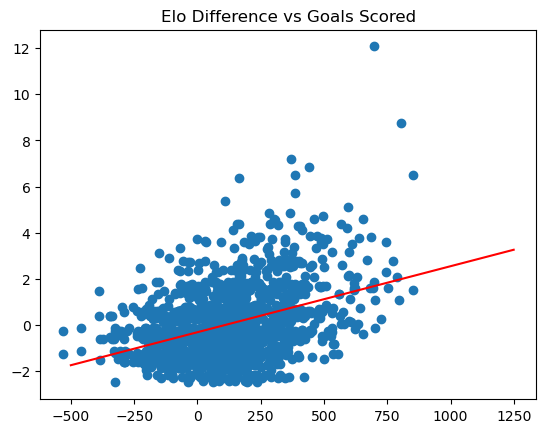

In [28]:
plt.title('Elo Difference vs Goals Scored')
plt.scatter(mega[0], mega[1])
x = np.arange(-500, 1250)
y = x*reg.coef_[0] + reg.intercept_[0]
plt.plot(x, y, color='red')

We can see that the expected goals we created adjust very well to the real number of goals in the matches. So we can use the poisson distribution to predict the results of the matches

The Poisson distribution is defined by the probability mass function:

𝑃(𝑋=𝑘)=𝜆𝑘𝑒−𝜆𝑘!

where:

𝑃(𝑋=𝑘) is the probability of 𝑘 goals being scored, λ is the average number of goals scored in a match.

In our context, 𝜆 represents the average number of goals a team is expected to score.

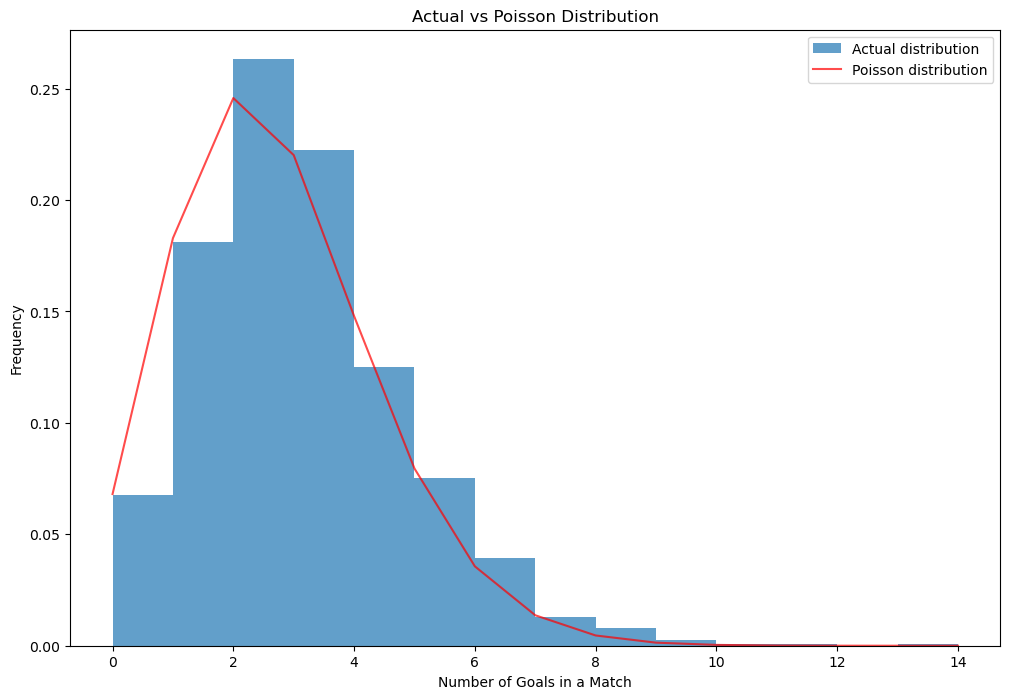

In [29]:
data = df2['total_score']

# Calculate the mean of the data as it will be the lambda (rate parameter) for the Poisson distribution
mu = data.mean()

# Create a range of numbers from 0 to the maximum number of goals in a match (this will be our x-axis)
k = np.arange(0, data.max()+1)

# Create a Poisson distribution with the mean obtained
poisson_pmf = poisson.pmf(k, mu)

plt.figure(figsize=(12,8))

# Plot the actual distribution of goals
plt.hist(data, bins=k, density=True, alpha=0.7, label='Actual distribution')

# Plot the Poisson distribution
plt.plot(k, poisson_pmf, 'r-', alpha=0.7, label='Poisson distribution')

plt.title('Actual vs Poisson Distribution')
plt.xlabel('Number of Goals in a Match')
plt.ylabel('Frequency')
plt.legend()

plt.show()

With the utilization of the given distribution, we can use the probabilities to predict the matches.

In [30]:
def calculate_match_probabilities(team_a_lambda, team_b_lambda, max_goals=10):
    # Create a matrix of zeros
    matrix = np.zeros((max_goals + 1, max_goals + 1))

    # Populate the matrix with probabilities
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            matrix[i, j] = poisson.pmf(i, team_a_lambda) * poisson.pmf(j, team_b_lambda)
    
    # Calculate the total goals probabilities
    total_goals_prob = [np.sum(np.diag(matrix[::-1], k)) for k in range(-(max_goals-1), max_goals+1)]

    # Calculate the probability for the specific result
    draw_prob = np.sum(np.diag(matrix))
    away_prob = np.sum(np.triu(matrix, 1))
    local_prob = np.sum(np.tril(matrix, -1))
    
    df_match_goals=pd.DataFrame(matrix)
    highest_value = df_match_goals.max().max()
    max_position = df_match_goals.stack().idxmax()
    h_goals=max_position[0]
    a_goals=max_position[1]
    

    return total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals


For instance, let's consider the inaugural match of the 2024 Euro between Germany and Scotland. Germany boasts an offensive power of 2.58, while Scotland 1.31.

Probability for France: 76.0 %
Probability for Albania: 7.000000000000001 %
Probability for draw: 17.0 %


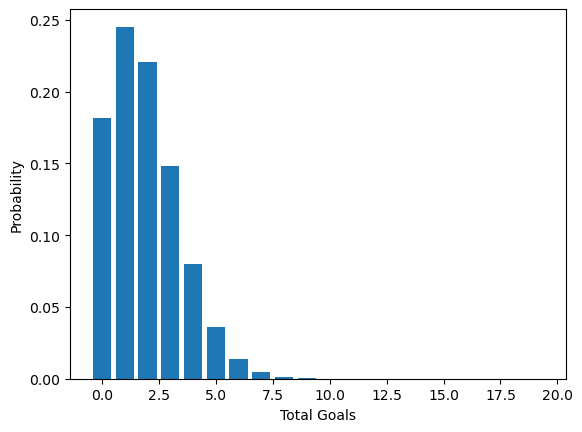

In [31]:
# Example usage
# Albania	1342.140	
# France	1752.570
# Albania	0.929605	0.945796	
# France	2.316062	0.543255	


team_a_lambda = 2.316062 * 0.945796 
team_b_lambda = 0.543255 * 0.929605
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals = calculate_match_probabilities(team_a_lambda, team_b_lambda)

# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for France: {round(local_prob,2)*100} %")
print(f"Probability for Albania: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

In [32]:
h_goals

2

In [33]:
a_goals

0

In [35]:
max(total_goals_prob)

0.24524717179817762

#  Adjusted Goals Expected with ELO and Poisson Distribution

In [36]:
def calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff,away_diff, max_goals=10):
    # Create a matrix of zeros
    matrix = np.zeros((max_goals + 1, max_goals + 1))

    # Populate the matrix with probabilities
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            matrix[i, j] = poisson.pmf(i, team_a_lambda) * poisson.pmf(j, team_b_lambda)
    
    # Calculate the total goals probabilities
    total_goals_prob = [np.sum(np.diag(matrix[::-1], k)) for k in range(-(max_goals-1), max_goals+1)]

    # Calculate the probability for the specific result
    draw_prob = np.sum(np.diag(matrix))
    away_prob = np.sum(np.triu(matrix, 1))
    local_prob = np.sum(np.tril(matrix, -1))
    
    df_match_goals=pd.DataFrame(matrix)
    highest_value = df_match_goals.max().max()
    max_position = df_match_goals.stack().idxmax()
    h_goals_adjust=int(reg.predict(np.array(home_diff).reshape(-1, 1)))
    a_goals_adjust=int(reg.predict(np.array(away_diff).reshape(-1, 1)))
    h_goals=int(max_position[0])
    a_goals=int(max_position[1])

    fin_h_goals=h_goals+h_goals_adjust
    fin_a_goals=a_goals+a_goals_adjust
    if (fin_a_goals==-1):
        adj_sum=abs(h_goals_adjust)+abs(a_goals_adjust)
        fin_h_goals+=adj_sum
        fin_a_goals+=1
    elif (fin_h_goals==-1):
        adj_sum=abs(h_goals_adjust)+abs(a_goals_adjust)
        fin_a_goals+=adj_sum
        fin_h_goals+=1
    

    return total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals

In [37]:
float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo'] )

1627.9500000000023

In [38]:

# home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo'])
# away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo'])
# print(f'home_diff : {home_diff}')
# print(f'away_diff : {away_diff}')

Probability for France: 76.0 %
Probability for Albania: 7.000000000000001 %
Probability for draw: 17.0 %


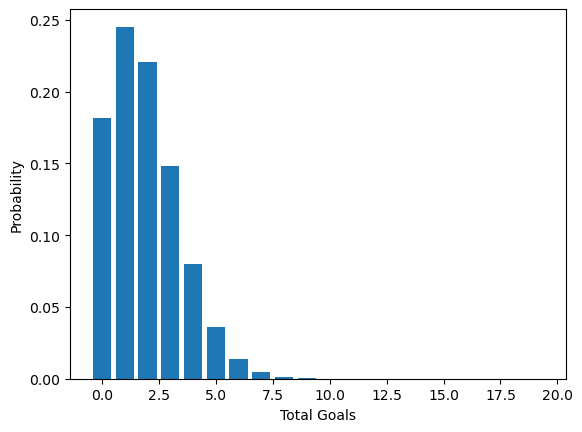

In [39]:
# Example usage
# Albania	1342.140	
# France	1752.570
# Albania	0.929605	0.945796	
# France	2.316062	0.543255	


team_a_lambda = 2.316062 * 0.945796 
team_b_lambda = 0.543255 * 0.929605
home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='France']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Albania']['Elo'])
away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Albania']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='France']['Elo'])
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff,away_diff)



# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for France: {round(local_prob,2)*100} %")
print(f"Probability for Albania: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

In [40]:
h_goals,a_goals

(2, 0)

In [41]:
fin_h_goals,fin_a_goals

(3, 0)

In [42]:
for x in range(-532,853):
    h_goals_adjust=int(reg.predict(np.array(x).reshape(-1, 1)))
    print(h_goals_adjust,x)

-1 -532
-1 -531
-1 -530
-1 -529
-1 -528
-1 -527
-1 -526
-1 -525
-1 -524
-1 -523
-1 -522
-1 -521
-1 -520
-1 -519
-1 -518
-1 -517
-1 -516
-1 -515
-1 -514
-1 -513
-1 -512
-1 -511
-1 -510
-1 -509
-1 -508
-1 -507
-1 -506
-1 -505
-1 -504
-1 -503
-1 -502
-1 -501
-1 -500
-1 -499
-1 -498
-1 -497
-1 -496
-1 -495
-1 -494
-1 -493
-1 -492
-1 -491
-1 -490
-1 -489
-1 -488
-1 -487
-1 -486
-1 -485
-1 -484
-1 -483
-1 -482
-1 -481
-1 -480
-1 -479
-1 -478
-1 -477
-1 -476
-1 -475
-1 -474
-1 -473
-1 -472
-1 -471
-1 -470
-1 -469
-1 -468
-1 -467
-1 -466
-1 -465
-1 -464
-1 -463
-1 -462
-1 -461
-1 -460
-1 -459
-1 -458
-1 -457
-1 -456
-1 -455
-1 -454
-1 -453
-1 -452
-1 -451
-1 -450
-1 -449
-1 -448
-1 -447
-1 -446
-1 -445
-1 -444
-1 -443
-1 -442
-1 -441
-1 -440
-1 -439
-1 -438
-1 -437
-1 -436
-1 -435
-1 -434
-1 -433
-1 -432
-1 -431
-1 -430
-1 -429
-1 -428
-1 -427
-1 -426
-1 -425
-1 -424
-1 -423
-1 -422
-1 -421
-1 -420
-1 -419
-1 -418
-1 -417
-1 -416
-1 -415
-1 -414
-1 -413
-1 -412
-1 -411
-1 -410
-1 -409
-1 -408


Probability for France: 7.000000000000001 %
Probability for Albania: 76.0 %
Probability for draw: 17.0 %


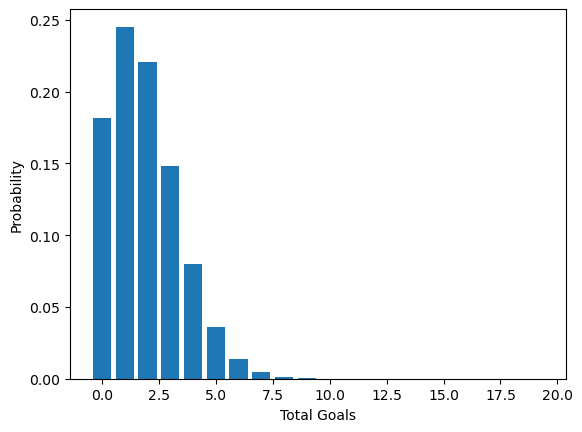

In [43]:
# Example usage
# Albania	1342.140	
# France	1752.570
# Albania	0.929605	0.945796	
# France	2.316062	0.543255	


team_b_lambda = 2.316062 * 0.945796 
team_a_lambda = 0.543255 * 0.929605
away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='France']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Albania']['Elo'])
home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Albania']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='France']['Elo'])
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff,away_diff)



# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for France: {round(local_prob,2)*100} %")
print(f"Probability for Albania: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

In [44]:
h_goals,a_goals

(0, 2)

In [45]:
fin_h_goals,fin_a_goals

(0, 3)

In [46]:
team_a_lambda = 2.316062 * 0.945796 
team_b_lambda = 0.543255 * 0.929605
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff=532,away_diff=-532)


In [47]:
h_goals,a_goals

(2, 0)

In [48]:
fin_h_goals,fin_a_goals

(5, 0)

In [49]:
team_a_lambda = 2.316062 * 0.945796 
team_b_lambda = 0.543255 * 0.929605
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals= calculate_match_probabilities_elo(team_b_lambda, team_a_lambda,home_diff=-532,away_diff=532)


In [50]:
h_goals,a_goals

(0, 2)

In [51]:
fin_h_goals,fin_a_goals

(0, 5)

Now it is time to validate if the probabilities given by the poisson distribution are accurate or not

In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1622 entries, 33959 to 47032
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           1622 non-null   object  
 1   home_team      1622 non-null   object  
 2   away_team      1622 non-null   object  
 3   home_score     1622 non-null   float64 
 4   away_score     1622 non-null   float64 
 5   tournament     1622 non-null   object  
 6   city           1622 non-null   object  
 7   country        1622 non-null   object  
 8   neutral        1622 non-null   bool    
 9   Elo_h_after    1622 non-null   float64 
 10  Elo_a_after    1622 non-null   float64 
 11  Elo_h_before   1622 non-null   float64 
 12  Elo_a_before   1622 non-null   float64 
 13  probH          1622 non-null   float64 
 14  probA          1622 non-null   float64 
 15  att_h_after    1622 non-null   float64 
 16  att_a_after    1622 non-null   float64 
 17  att_h_before   1622 non-null   fl

In [54]:
df_euro=df2.copy()
# Function to apply to each row of the DataFrame
def apply_calculation_elo(row):
#     home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo'])
#     away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo'])
    total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(row['XGhome'], row['XGaway'],row['home_diff_elo'],row['away_diff_elo'])
    return pd.Series({
        'total_goals_prob': total_goals_prob,
        'draw_prob': draw_prob,
        'away_prob': away_prob,
        'local_prob': local_prob,
        'home_goals': h_goals,
        'away_goals': a_goals,
         'home_goals_elo': fin_h_goals,
        'away_goals_elo': fin_a_goals,
    })

# Apply the function to each row
calculated_variables = df_euro.apply(apply_calculation_elo, axis=1)

# Concatenate the result with the original DataFrame
matches_df = pd.concat([df_euro, calculated_variables], axis=1)

df_euro[['total_goals_prob', 'draw_prob', 'away_prob', 'local_prob','home_goals' ,'away_goals','home_goals_elo','away_goals_elo']] = df_euro[['XGhome','XGaway','home_diff_elo','away_diff_elo']].apply(apply_calculation_elo, axis=1)

# Iterate over each row in the DataFrame
for index, row in df_euro.iterrows():
    # Iterate over each element in the 'total_goals_prob' list
    for i, prob in enumerate(row['total_goals_prob']):
        # Create new column with the name 'prob_index_goals_i' and assign the corresponding value
        df_euro.at[index, f'prob_index_goals_{i}'] = prob

<Figure size 1200x600 with 0 Axes>

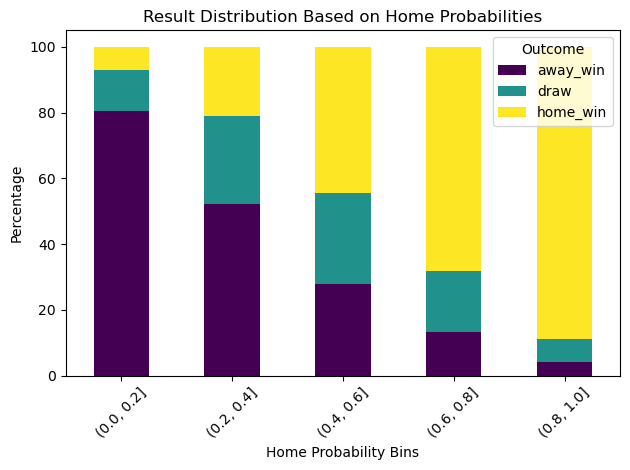

In [55]:
# Compute the actual outcome based on the home and away scores
df_euro['result'] = np.where(df_euro['home_score'] > df_euro['away_score'], 'home_win',
                                 np.where(df_euro['home_score'] == df_euro['away_score'], 'draw', 'away_win'))

df_euro['home_win_flag'] = np.where(df_euro['result']=='home_win', 1,0)
df_euro['draw_flag'] = np.where(df_euro['result']=='draw', 1,0)
df_euro['away_win_flag'] = np.where(df_euro['result']=='away_win', 1,0)
# Define bins for grouping based on predicted probabilities (adjust as needed)
bins = [0, 0.2, 0.4,0.6, 0.8,1]

# Create a new column indicating the bin for each match based on predicted probabilities
df_euro['probability_bin'] = pd.cut(df_euro['local_prob'], bins=bins)

# Group the DataFrame by the probability bins and compute the percentage of actual outcomes within each group
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100

# Plotting the result distribution based on home probabilities
plt.figure(figsize=(12, 6))
result_distribution.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Result Distribution Based on Home Probabilities')
plt.xlabel('Home Probability Bins')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()

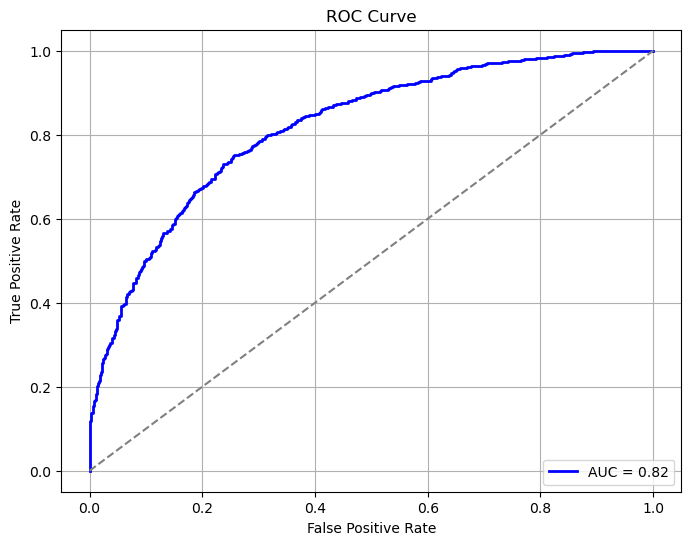

AUC: 0.82


In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(df_euro['home_win_flag'], df_euro['local_prob'])

# Compute AUC
auc = roc_auc_score(df_euro['home_win_flag'], df_euro['local_prob'])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {auc:.2f}")

It can be seen that the probabilities for home winning are working good.

In [57]:
# Create a new column indicating the bin for each match based on predicted probabilities
bins = [0, 0.15, 0.3,0.6,1]
df_euro['probability_bin'] = pd.cut(df_euro['away_prob'], bins=bins)

# Group the DataFrame by the probability bins and compute the percentage of actual outcomes within each group
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100
print(result_distribution)
# Compute AUC
auc_away = roc_auc_score(df_euro['away_win_flag'], df_euro['away_prob'])

print(f"AUC: {auc_away:.2f}")

result            away_win       draw   home_win
probability_bin                                 
(0.0, 0.15]       7.984791  13.498099  78.517110
(0.15, 0.3]      25.454545  27.727273  46.818182
(0.3, 0.6]       53.677932  25.844930  20.477137
(0.6, 1.0]       87.581699   7.843137   4.575163
AUC: 0.82


It can be said the same for the away probabilities, 
so we can conclude that this predictions are relative good for the matches in Euro.

# 2024 Euro Prediction

Once we have the probabilities, we can finally use it to predict the results of the 2024 Euro. Let see it.

In [58]:
matches_data = [
    # Grupo A
    {"Grupo": "A", "Home_Team": "Germany", "Away_Team": "Scotland"},
    {"Grupo": "A", "Home_Team": "Hungary", "Away_Team": "Switzerland"},
    {"Grupo": "A", "Home_Team": "Germany", "Away_Team": "Hungary"},
    {"Grupo": "A", "Home_Team": "Scotland", "Away_Team": "Switzerland"},
    {"Grupo": "A", "Home_Team": "Switzerland", "Away_Team": "Germany"},
    {"Grupo": "A", "Home_Team": "Scotland", "Away_Team": "Hungary"},
    # Grupo B
    {"Grupo": "B", "Home_Team": "Spain", "Away_Team": "Croatia"},
    {"Grupo": "B", "Home_Team": "Italy", "Away_Team": "Albania"},
    {"Grupo": "B", "Home_Team": "Croatia", "Away_Team": "Albania"},
    {"Grupo": "B", "Home_Team": "Spain", "Away_Team": "Italy"},
    {"Grupo": "B", "Home_Team": "Albania", "Away_Team": "Spain"},
    {"Grupo": "B", "Home_Team": "Croatia", "Away_Team": "Italy"},
    # Grupo C
    {"Grupo": "C", "Home_Team": "Slovenia", "Away_Team": "Denmark"},
    {"Grupo": "C", "Home_Team": "Serbia", "Away_Team": "England"},
    {"Grupo": "C", "Home_Team": "Slovenia", "Away_Team": "Serbia"},
    {"Grupo": "C", "Home_Team": "Denmark", "Away_Team": "England"},
    {"Grupo": "C", "Home_Team": "England", "Away_Team": "Slovenia"},
    {"Grupo": "C", "Home_Team": "Denmark", "Away_Team": "Serbia"},
    # Grupo D
    {"Grupo": "D", "Home_Team": "Poland", "Away_Team": "Netherlands"},
    {"Grupo": "D", "Home_Team": "Austria", "Away_Team": "France"},
    {"Grupo": "D", "Home_Team": "Poland", "Away_Team": "Austria"},
    {"Grupo": "D", "Home_Team": "Netherlands", "Away_Team": "France"},
    {"Grupo": "D", "Home_Team": "Netherlands", "Away_Team": "Austria"},
    {"Grupo": "D", "Home_Team": "France", "Away_Team": "Poland"},
    # Grupo E
    {"Grupo": "E", "Home_Team": "Romania", "Away_Team": "Ukraine"},
    {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Slovakia"},
    {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Ukraine"},
    {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Romania"},
    {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Romania"},
    {"Grupo": "E", "Home_Team": "Ukraine", "Away_Team": "Belgium"},
    # Grupo F
    {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Georgia"},
    {"Grupo": "F", "Home_Team": "Portugal", "Away_Team": "Czech Republic"},
    {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Czech Republic"},
    {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Portugal"},
    {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Portugal"},
    {"Grupo": "F", "Home_Team": "Czech Republic", "Away_Team": "Turkey"},
]

# Create a dataframe
matches_df = pd.DataFrame(matches_data)

In [59]:
elos

date                              Team       Elo  position
0    2024-06-09                         Argentina  1771.075         1
1    2024-06-09                            France  1752.570         2
2    2024-06-08                            Brazil  1707.530         3
3    2024-06-10                       Netherlands  1683.040         4
4    2024-06-08                           Belgium  1681.085         5
5    2024-06-07                           England  1680.295         6
6    2024-06-08                             Spain  1673.275         7
7    2024-06-09                             Italy  1658.860         8
8    2024-06-11                          Portugal  1650.725         9
9    2024-06-08                          Colombia  1648.195        10
10   2024-06-05                           Uruguay  1633.475        11
11   2024-06-08                           Croatia  1628.730        12
12   2024-06-07                           Germany  1627.950        13
13   2024-06-11                             Japan  1606.200        14
14   2024-06-11                              Iran  1579.440        15
15   2024-06-09                           Senegal  1572.650        16
16   2024-06-11                           Morocco  1557.500        17
17   2024-06-08                            Mexico  1557.040        18
18   2024-06-08                       Switzerland  1554.315        19
19   2024-06-11                         Australia  1552.985        20
20   2024-06-11                       South Korea  1549.620        21
21   2024-06-08                     United States  1547.805        22
22   2024-06-08                           Denmark  1546.950        23
23   2024-06-09                           Ecuador  1544.750        24
24   2024-06-11                           Ukraine  1526.900        25
25   2024-06-11                             Qatar  1520.015        26
26   2024-06-11                       Ivory Coast  1517.195        27
27   2024-06-07                            Russia  1511.040        28
28   2024-06-08                           Hungary  1506.305        29
29   2024-06-08                           Austria  1503.390        30
30   2024-06-10                            Poland  1495.190        31
31   2024-06-08                            Serbia  1495.055        32
32   2024-06-07                              Peru  1493.045        33
33   1999-12-23                        Yugoslavia  1491.810        34
34   2024-06-09                        Costa Rica  1488.800        35
35   2024-06-10                             Egypt  1487.195        36
36   2024-06-11                        Uzbekistan  1483.150        37
37   2024-06-10                    Czech Republic  1482.325        38
38   2024-06-08                            Sweden  1479.280        39
39   2024-06-11                             Chile  1477.060        40
40   2024-06-11                              Iraq  1475.655        41
41   2024-06-07                          Scotland  1469.430        42
42   2024-06-10                            Turkey  1466.605        43
43   2024-06-11                      Saudi Arabia  1466.380        44
44   2024-06-09                             Wales  1462.595        45
45   2024-06-10                           Algeria  1459.885        46
46   2024-06-10                           Nigeria  1459.805        47
47   1992-11-14                    Czechoslovakia  1454.940        48
48   2024-06-09                           Tunisia  1454.880        49
49   2024-06-11                          Cameroon  1451.485        50
50   2024-06-11                            Jordan  1450.925        51
51   2024-06-11                            Greece  1449.440        52
52   2024-03-24                         Venezuela  1448.450        53
53   2024-06-08                            Norway  1444.285        54
54   2024-06-09                            Panama  1439.205        55
55   2024-06-09                            Canada  1438.960        56
56   2024-06-11      

In [60]:
merged_df = pd.merge(matches_df, attdef[["Team", "att", "def"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
merged_df_elo = pd.merge(merged_df, elos[["Team","Elo"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
group_matches_elo = pd.merge(merged_df_elo, attdef[["Team", "att", "def"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")
group_matches= pd.merge(group_matches_elo, elos[["Team","Elo"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")
group_matches

Grupo       Home_Team       Away_Team  Home_att  Home_def  Home_Elo  \
0      A         Germany        Scotland  2.568137  0.736362  1627.950   
1      A         Hungary     Switzerland  1.364134  0.911723  1506.305   
2      A         Germany         Hungary  2.568137  0.736362  1627.950   
3      A        Scotland     Switzerland  1.315495  0.861902  1469.430   
4      A     Switzerland         Germany  1.731058  0.783603  1554.315   
5      A        Scotland         Hungary  1.315495  0.861902  1469.430   
6      B           Spain         Croatia  2.556965  0.504760  1673.275   
7      B           Italy         Albania  1.812726  0.515376  1658.860   
8      B         Croatia         Albania  1.906891  0.624911  1628.730   
9      B           Spain           Italy  2.556965  0.504760  1673.275   
10     B         Albania           Spain  0.929605  0.945796  1342.140   
11     B         Croatia           Italy  1.906891  0.624911  1628.730   
12     C        Slovenia         Denmark  1.203744  0.852783  1419.585   
13     C          Serbia         England  1.789521  0.889672  1495.055   
14     C        Slovenia          Serbia  1.203744  0.852783  1419.585   
15     C         Denmark         England  1.720159  0.626862  1546.950   
16     C         England        Slovenia  2.232232  0.492452  1680.295   
17     C         Denmark          Serbia  1.720159  0.626862  1546.950   
18     D          Poland     Netherlands  1.607147  0.810224  1495.190   
19     D         Austria          France  1.534476  0.861345  1503.390   
20     D          Poland         Austria  1.607147  0.810224  1495.190   
21     D     Netherlands          France  2.370050  0.622326  1683.040   
22     D     Netherlands         Austria  2.370050  0.622326  1683.040   
23     D          France          Poland  2.316062  0.543255  1752.570   
24     E         Romania         Ukraine  1.304309  0.786796  1414.880   
25     E         Belgium        Slovakia  2.282870  0.564715  1681.085   
26     E        Slovakia         Ukraine  1.322737  0.865465  1403.825   
27     E         Belgium         Romania  2.282870  0.564715  1681.085   
28     E        Slovakia         Romania  1.322737  0.865465  1403.825   
29     E         Ukraine         Belgium  1.498727  0.732182  1526.900   
30     F          Turkey         Georgia  1.561179  0.915570  1466.605   
31     F        Portugal  Czech Republic  2.299713  0.574171  1650.725   
32     F         Georgia  Czech Republic  1.149717  1.020186  1362.370   
33     F          Turkey        Portugal  1.561179  0.915570  1466.605   
34     F         Georgia        Portugal  1.149717  1.020186  1362.370   
35     F  Czech Republic          Turkey  1.581925  0.773698  1482.325   

    Away_att  Away_def  Away_Elo  
0   1.315495  0.861902  1469.430  
1   1.731058  0.783603  1554.315  
2   1.364134  0.911723  1506.305  
3   1.731058  0.783603  1554.315  
4   2.568137  0.736362  1627.950  
5   1.364134  0.911723  1506.305  
6   1.906891  0.624911  1628.730  
7   0.929605  0.945796  1342.140  
8   0.929605  0.945796  1342.140  
9   1.812726  0.515376  1658.860  
10  2.556965  0.504760  1673.275  
11  1.812726  0.515376  1658.860  
12  1.720159  0.626862  1546.950  
13  2.232232  0.492452  1680.295  
14  1.789521  0.889672  1495.055  
15  2.232232  0.492452  1680.295  
16  1.203744  0.852783  1419.585  
17  1.789521  0.889672  1495.055  
18  2.370050  0.622326  1683.040  
19  2.316062  0.543255  1752.570  
20  1.534476  0.861345  1503.390  
21  2.316062  0.543255  1752.570  
22  1.534476  0.861345  1503.390  
23  1.607147  0.810224  1495.190  
24  1.498727  0.732182  1526.900  
25  1.322737  0.865465  1403.825  
26  1.498727  0.732182  1526.900  
27  1.304309  0.786796  1414.880  
28  1.304309  0.786796  1414.880  
29  2.282870  0.564715  1681.085  
30  1.149717  1.020186  1362.370  
31  1.581925  0.773698  1482.325  
32  1.581925  0.773698  1482.325  
33  2.299713  0.574171  1650.725  
34  2.299713  0.574171  1650.725  
35  

In [61]:
#Computing the expected goals
group_matches['XGhome']=group_matches['Home_att']*group_matches['Away_def']
group_matches['XGaway']=group_matches['Home_def']*group_matches['Away_att']
group_matches['home_diff_elo']=group_matches['Home_Elo']-group_matches['Away_Elo']
group_matches['away_diff_elo']=group_matches['Away_Elo']-group_matches['Home_Elo']

group_matches[['total_goals_prob', 'draw_prob', 'away_prob', 'local_prob','home_goals','away_goals','home_goals_elo','away_goals_elo']] = group_matches[['XGhome','XGaway','home_diff_elo','away_diff_elo']].apply(apply_calculation_elo, axis=1)
group_matches.drop("total_goals_prob",axis=1, inplace=True)

In [62]:
# #Computing the expected goals
# group_matches_elo=group_matches.copy()
# group_matches_elo['XGhome']=group_matches_elo['Home_att']*group_matches_elo['Away_def']
# group_matches_elo['XGaway']=group_matches_elo['Home_def']*group_matches_elo['Away_att']

# group_matches_elo[['total_goals_prob', 'draw_prob', 'away_prob', 'local_prob','home_goals','away_goals']] = group_matches_elo[['XGhome','XGaway']].apply(apply_calculation, axis=1)
# group_matches_elo.drop("total_goals_prob",axis=1, inplace=True)

In [63]:
group_matches

Grupo       Home_Team       Away_Team  Home_att  Home_def  Home_Elo  \
0      A         Germany        Scotland  2.568137  0.736362  1627.950   
1      A         Hungary     Switzerland  1.364134  0.911723  1506.305   
2      A         Germany         Hungary  2.568137  0.736362  1627.950   
3      A        Scotland     Switzerland  1.315495  0.861902  1469.430   
4      A     Switzerland         Germany  1.731058  0.783603  1554.315   
5      A        Scotland         Hungary  1.315495  0.861902  1469.430   
6      B           Spain         Croatia  2.556965  0.504760  1673.275   
7      B           Italy         Albania  1.812726  0.515376  1658.860   
8      B         Croatia         Albania  1.906891  0.624911  1628.730   
9      B           Spain           Italy  2.556965  0.504760  1673.275   
10     B         Albania           Spain  0.929605  0.945796  1342.140   
11     B         Croatia           Italy  1.906891  0.624911  1628.730   
12     C        Slovenia         Denmark  1.203744  0.852783  1419.585   
13     C          Serbia         England  1.789521  0.889672  1495.055   
14     C        Slovenia          Serbia  1.203744  0.852783  1419.585   
15     C         Denmark         England  1.720159  0.626862  1546.950   
16     C         England        Slovenia  2.232232  0.492452  1680.295   
17     C         Denmark          Serbia  1.720159  0.626862  1546.950   
18     D          Poland     Netherlands  1.607147  0.810224  1495.190   
19     D         Austria          France  1.534476  0.861345  1503.390   
20     D          Poland         Austria  1.607147  0.810224  1495.190   
21     D     Netherlands          France  2.370050  0.622326  1683.040   
22     D     Netherlands         Austria  2.370050  0.622326  1683.040   
23     D          France          Poland  2.316062  0.543255  1752.570   
24     E         Romania         Ukraine  1.304309  0.786796  1414.880   
25     E         Belgium        Slovakia  2.282870  0.564715  1681.085   
26     E        Slovakia         Ukraine  1.322737  0.865465  1403.825   
27     E         Belgium         Romania  2.282870  0.564715  1681.085   
28     E        Slovakia         Romania  1.322737  0.865465  1403.825   
29     E         Ukraine         Belgium  1.498727  0.732182  1526.900   
30     F          Turkey         Georgia  1.561179  0.915570  1466.605   
31     F        Portugal  Czech Republic  2.299713  0.574171  1650.725   
32     F         Georgia  Czech Republic  1.149717  1.020186  1362.370   
33     F          Turkey        Portugal  1.561179  0.915570  1466.605   
34     F         Georgia        Portugal  1.149717  1.020186  1362.370   
35     F  Czech Republic          Turkey  1.581925  0.773698  1482.325   

    Away_att  Away_def  Away_Elo    XGhome    XGaway  home_diff_elo  \
0   1.315495  0.861902  1469.430  2.213483  0.968680        158.520   
1   1.731058  0.783603  1554.315  1.068940  1.578246        -48.010   
2   1.364134  0.911723  1506.305  2.341430  1.004496        121.645   
3   1.731058  0.783603  1554.315  1.030826  1.492003        -84.885   
4   2.568137  0.736362  1627.950  1.274685  2.012401        -73.635   
5   1.364134  0.911723  1506.305  1.199367  1.175750        -36.875   
6   1.906891  0.624911  1628.730  1.597877  0.962523         44.545   
7   0.929605  0.945796  1342.140  1.714469  0.479096        316.720   
8   0.929605  0.945796  1342.140  1.803530  0.580921        286.590   
9   1.812726  0.515376  1658.860  1.317798  0.914992         14.415   
10  2.556965  0.504760  1673.275  0.469228  2.418368       -331.135   
11  1.812726  0.515376  1658.860  0.982765  1.132793        -30.130   
12  1.720159  0.626862  1546.950  0.754581  1.466923       -127.365   
13  2.232232  0.492452  1680.295  0.881253  1.985955       -185.240   
14  1.789521  0.889672  1495.055  1.070937  1.526074        -75.470   
15  2.232232  0.492452  1680.295  0.847095  1.399301       -133.345   
16  1.203744  0.852783  1419.585  1.903610  0.592786     

In [64]:
# Define a function to determine the result based on probabilities
def determine_result_random(row):
#     np.random.seed(1)  # Note: Setting the seed inside the function will make the randomness not very random across multiple calls
    random_number = np.random.random()
    
    if random_number < row["draw_prob"]:
        return pd.Series(["Draw", random_number])
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return pd.Series([row["Away_Team"], random_number])
    else:
        return pd.Series([row["Home_Team"], random_number])

def determine_result(row):
#     max_prob = max(row["draw_prob"], row["away_prob"], row["local_prob"])

    if row["home_goals_elo"] == row["away_goals_elo"]:
        return "Draw"
    elif row["away_goals_elo"] > row["away_goals_elo"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
def determine_result_knockout(row):
    if row["away_prob"] >row["home_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
def determine_result_knockout_random(row):
    random_number = np.random.random()
    if random_number < row["draw_prob"]:
        random_number2 = np.random.random()
        if random_number < 0.5:
            return row["Away_Team"]
        else:
            return row["Home_Team"]
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
# Apply the function to create the "Results" column
group_matches["Result"] = group_matches.apply(determine_result, axis=1)


We can see the predictions for each match, based on the expexted goals, we simulate the number of goals scored by each team in a match.

In [65]:
for x in range(-532,853):
    h_goals_adjust=int(reg.predict(np.array(x).reshape(-1, 1)))
    print(h_goals_adjust,x)

-1 -532
-1 -531
-1 -530
-1 -529
-1 -528
-1 -527
-1 -526
-1 -525
-1 -524
-1 -523
-1 -522
-1 -521
-1 -520
-1 -519
-1 -518
-1 -517
-1 -516
-1 -515
-1 -514
-1 -513
-1 -512
-1 -511
-1 -510
-1 -509
-1 -508
-1 -507
-1 -506
-1 -505
-1 -504
-1 -503
-1 -502
-1 -501
-1 -500
-1 -499
-1 -498
-1 -497
-1 -496
-1 -495
-1 -494
-1 -493
-1 -492
-1 -491
-1 -490
-1 -489
-1 -488
-1 -487
-1 -486
-1 -485
-1 -484
-1 -483
-1 -482
-1 -481
-1 -480
-1 -479
-1 -478
-1 -477
-1 -476
-1 -475
-1 -474
-1 -473
-1 -472
-1 -471
-1 -470
-1 -469
-1 -468
-1 -467
-1 -466
-1 -465
-1 -464
-1 -463
-1 -462
-1 -461
-1 -460
-1 -459
-1 -458
-1 -457
-1 -456
-1 -455
-1 -454
-1 -453
-1 -452
-1 -451
-1 -450
-1 -449
-1 -448
-1 -447
-1 -446
-1 -445
-1 -444
-1 -443
-1 -442
-1 -441
-1 -440
-1 -439
-1 -438
-1 -437
-1 -436
-1 -435
-1 -434
-1 -433
-1 -432
-1 -431
-1 -430
-1 -429
-1 -428
-1 -427
-1 -426
-1 -425
-1 -424
-1 -423
-1 -422
-1 -421
-1 -420
-1 -419
-1 -418
-1 -417
-1 -416
-1 -415
-1 -414
-1 -413
-1 -412
-1 -411
-1 -410
-1 -409
-1 -408


In [66]:
group_matches[group_matches['away_diff_elo']<-243]

Grupo Home_Team Away_Team  Home_att  Home_def  Home_Elo  Away_att  \
7      B     Italy   Albania  1.812726  0.515376  1658.860  0.929605   
8      B   Croatia   Albania  1.906891  0.624911  1628.730  0.929605   
16     C   England  Slovenia  2.232232  0.492452  1680.295  1.203744   
23     D    France    Poland  2.316062  0.543255  1752.570  1.607147   
25     E   Belgium  Slovakia  2.282870  0.564715  1681.085  1.322737   
27     E   Belgium   Romania  2.282870  0.564715  1681.085  1.304309   

    Away_def  Away_Elo    XGhome    XGaway  home_diff_elo  away_diff_elo  \
7   0.945796  1342.140  1.714469  0.479096        316.720       -316.720   
8   0.945796  1342.140  1.803530  0.580921        286.590       -286.590   
16  0.852783  1419.585  1.903610  0.592786        260.710       -260.710   
23  0.810224  1495.190  1.876528  0.873090        257.380       -257.380   
25  0.865465  1403.825  1.975744  0.746969        277.260       -277.260   
27  0.786796  1414.880  1.796154  0.736562        266.205       -266.205   

    draw_prob  away_prob  local_prob  home_goals  away_goals  home_goals_elo  \
7    0.223737   0.098089    0.678172           1           0               2   
8    0.217105   0.113143    0.669749           1           0               2   
16   0.205099   0.107192    0.687703           1           0               2   
23   0.220314   0.169713    0.609968           1           0               2   
25   0.204865   0.132392    0.662736           1           0               2   
27   0.224862   0.148288    0.626847           1           0               2   

    away_goals_elo   Result  
7                0    Italy  
8                0  Croatia  
16               0  England  
23               0   France  
25               0  Belgium  
27               0  Belgium

In [67]:
group_matches[group_matches['home_diff_elo']<-243]

Grupo Home_Team Away_Team  Home_att  Home_def  Home_Elo  Away_att  \
10     B   Albania     Spain  0.929605  0.945796   1342.14  2.556965   
19     D   Austria    France  1.534476  0.861345   1503.39  2.316062   
34     F   Georgia  Portugal  1.149717  1.020186   1362.37  2.299713   

    Away_def  Away_Elo    XGhome    XGaway  home_diff_elo  away_diff_elo  \
10  0.504760  1673.275  0.469228  2.418368       -331.135        331.135   
19  0.543255  1752.570  0.833611  1.994929       -249.180        249.180   
34  0.574171  1650.725  0.660134  2.346135       -288.355        288.355   

    draw_prob  away_prob  local_prob  home_goals  away_goals  home_goals_elo  \
10   0.139291   0.806378    0.054285           0           2               0   
19   0.206630   0.645047    0.148315           0           1               0   
34   0.161403   0.751577    0.086984           0           2               0   

    away_goals_elo   Result  
10               3  Albania  
19               2  Austria  
34               3  Georgia

In [68]:
group_matches[group_matches.Grupo=="A"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

Home_Team    Away_Team  local_prob  draw_prob  away_prob  home_goals  \
0      Germany     Scotland    0.656070   0.191186   0.152723           2   
1      Hungary  Switzerland    0.257244   0.251308   0.491448           1   
2      Germany      Hungary    0.671687   0.181589   0.146690           2   
3     Scotland  Switzerland    0.261523   0.260013   0.478463           1   
4  Switzerland      Germany    0.239727   0.215303   0.544961           1   
5     Scotland      Hungary    0.366599   0.278309   0.355092           1   

   away_goals  home_goals_elo  away_goals_elo  home_diff_elo    XGhome  \
0           0               2               0        158.520  2.213483   
1           1               1               1        -48.010  1.068940   
2           1               2               1        121.645  2.341430   
3           1               1               1        -84.885  1.030826   
4           2               1               2        -73.635  1.274685   
5           1               1               1        -36.875  1.199367   

     XGaway       Result  
0  0.968680      Germany  
1  1.578246         Draw  
2  1.004496      Germany  
3  1.492003         Draw  
4  2.012401  Switzerland  
5  1.175750         Draw

In [69]:
group_matches[group_matches.Grupo=="B"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

Home_Team Away_Team  local_prob  draw_prob  away_prob  home_goals  \
6      Spain   Croatia    0.522069   0.250425   0.227505           1   
7      Italy   Albania    0.678172   0.223737   0.098089           1   
8    Croatia   Albania    0.669749   0.217105   0.113143           1   
9      Spain     Italy    0.459435   0.281132   0.259432           1   
10   Albania     Spain    0.054285   0.139291   0.806378           0   
11   Croatia     Italy    0.313103   0.297102   0.389795           0   

    away_goals  home_goals_elo  away_goals_elo  home_diff_elo    XGhome  \
6            0               1               0         44.545  1.597877   
7            0               2               0        316.720  1.714469   
8            0               2               0        286.590  1.803530   
9            0               1               0         14.415  1.317798   
10           2               0               3       -331.135  0.469228   
11           1               0               1        -30.130  0.982765   

      XGaway   Result  
6   0.962523    Spain  
7   0.479096    Italy  
8   0.580921  Croatia  
9   0.914992    Spain  
10  2.418368  Albania  
11  1.132793  Croatia

In [70]:
group_matches[group_matches.Grupo=="C"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

Home_Team Away_Team  local_prob  draw_prob  away_prob  home_goals  \
12  Slovenia   Denmark    0.192546   0.266086   0.541368           0   
13    Serbia   England    0.159177   0.209364   0.631452           0   
14  Slovenia    Serbia    0.266246   0.256011   0.477742           1   
15   Denmark   England    0.227356   0.273595   0.499049           0   
16   England  Slovenia    0.687703   0.205099   0.107192           1   
17   Denmark    Serbia    0.466974   0.254520   0.278505           1   

    away_goals  home_goals_elo  away_goals_elo  home_diff_elo    XGhome  \
12           1               0               1       -127.365  0.754581   
13           1               0               1       -185.240  0.881253   
14           1               1               1        -75.470  1.070937   
15           1               0               1       -133.345  0.847095   
16           0               2               0        260.710  1.903610   
17           1               1               1         51.895  1.530378   

      XGaway    Result  
12  1.466923  Slovenia  
13  1.985955    Serbia  
14  1.526074      Draw  
15  1.399301   Denmark  
16  0.592786   England  
17  1.121783      Draw

In [71]:
group_matches[group_matches.Grupo=="D"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

Home_Team    Away_Team  local_prob  draw_prob  away_prob  home_goals  \
18       Poland  Netherlands    0.192363   0.219149   0.588482           1   
19      Austria       France    0.148315   0.206630   0.645047           0   
20       Poland      Austria    0.402102   0.261523   0.336375           1   
21  Netherlands       France    0.336899   0.255717   0.407383           1   
22  Netherlands      Austria    0.625128   0.206491   0.168371           2   
23       France       Poland    0.609968   0.220314   0.169713           1   

    away_goals  home_goals_elo  away_goals_elo  home_diff_elo    XGhome  \
18           1               1               1        -187.85  1.000169   
19           1               0               2        -249.18  0.833611   
20           1               1               1          -8.20  1.384308   
21           1               1               1         -69.53  1.287541   
22           0               2               0         179.65  2.041431   
23           0               2               0         257.38  1.876528   

      XGaway       Result  
18  1.920270         Draw  
19  1.994929      Austria  
20  1.243268         Draw  
21  1.441345         Draw  
22  0.954944  Netherlands  
23  0.873090       France

In [72]:
group_matches[group_matches.Grupo=="E"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

Home_Team Away_Team  local_prob  draw_prob  away_prob  home_goals  \
24   Romania   Ukraine    0.295897   0.294166   0.409937           0   
25   Belgium  Slovakia    0.662736   0.204865   0.132392           1   
26  Slovakia   Ukraine    0.278087   0.281253   0.440660           0   
27   Belgium   Romania    0.626847   0.224862   0.148288           1   
28  Slovakia   Romania    0.331012   0.293378   0.375610           1   
29   Ukraine   Belgium    0.188656   0.241982   0.569361           0   

    away_goals  home_goals_elo  away_goals_elo  home_diff_elo    XGhome  \
24           1               0               1       -112.020  0.954991   
25           0               2               0        277.260  1.975744   
26           1               0               1       -123.075  0.968484   
27           0               2               0        266.205  1.796154   
28           1               1               1        -11.055  1.040725   
29           1               0               1       -154.185  0.846353   

      XGaway    Result  
24  1.179193   Romania  
25  0.746969   Belgium  
26  1.297096  Slovakia  
27  0.736562   Belgium  
28  1.128833      Draw  
29  1.671475   Ukraine

In [73]:
group_matches[group_matches.Grupo=="F"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

Home_Team       Away_Team  local_prob  draw_prob  away_prob  \
30          Turkey         Georgia    0.498940   0.250196   0.250862   
31        Portugal  Czech Republic    0.579234   0.231284   0.189479   
32         Georgia  Czech Republic    0.206986   0.248759   0.544254   
33          Turkey        Portugal    0.149655   0.198191   0.652141   
34         Georgia        Portugal    0.086984   0.161403   0.751577   
35  Czech Republic          Turkey    0.426463   0.258433   0.315103   

    home_goals  away_goals  home_goals_elo  away_goals_elo  home_diff_elo  \
30           1           1               1               1        104.235   
31           1           0               1               0        168.400   
32           0           1               0               1       -119.955   
33           0           2               0               2       -184.120   
34           0           2               0               3       -288.355   
35           1           1               1               1         15.720   

      XGhome    XGaway    Result  
30  1.592693  1.052647      Draw  
31  1.779283  0.908295  Portugal  
32  0.889534  1.613858   Georgia  
33  0.896384  2.105549    Turkey  
34  0.660134  2.346135   Georgia  
35  1.448363  1.207881      Draw

By running numerous simulations, we can estimate the probabilities of different outcomes for each match.
We simulate each match multiple times to predict the likely outcomes and the points each team might accumulate. The table presented below illustrates the predicted probabilities for each team to conclude the group stage in a particular position.

In [74]:
group_matches[group_matches['Result']=='Draw']

Grupo       Home_Team    Away_Team  Home_att  Home_def  Home_Elo  Away_att  \
1      A         Hungary  Switzerland  1.364134  0.911723  1506.305  1.731058   
3      A        Scotland  Switzerland  1.315495  0.861902  1469.430  1.731058   
5      A        Scotland      Hungary  1.315495  0.861902  1469.430  1.364134   
14     C        Slovenia       Serbia  1.203744  0.852783  1419.585  1.789521   
17     C         Denmark       Serbia  1.720159  0.626862  1546.950  1.789521   
18     D          Poland  Netherlands  1.607147  0.810224  1495.190  2.370050   
20     D          Poland      Austria  1.607147  0.810224  1495.190  1.534476   
21     D     Netherlands       France  2.370050  0.622326  1683.040  2.316062   
28     E        Slovakia      Romania  1.322737  0.865465  1403.825  1.304309   
30     F          Turkey      Georgia  1.561179  0.915570  1466.605  1.149717   
35     F  Czech Republic       Turkey  1.581925  0.773698  1482.325  1.561179   

    Away_def  Away_Elo    XGhome    XGaway  home_diff_elo  away_diff_elo  \
1   0.783603  1554.315  1.068940  1.578246        -48.010         48.010   
3   0.783603  1554.315  1.030826  1.492003        -84.885         84.885   
5   0.911723  1506.305  1.199367  1.175750        -36.875         36.875   
14  0.889672  1495.055  1.070937  1.526074        -75.470         75.470   
17  0.889672  1495.055  1.530378  1.121783         51.895        -51.895   
18  0.622326  1683.040  1.000169  1.920270       -187.850        187.850   
20  0.861345  1503.390  1.384308  1.243268         -8.200          8.200   
21  0.543255  1752.570  1.287541  1.441345        -69.530         69.530   
28  0.786796  1414.880  1.040725  1.128833        -11.055         11.055   
30  1.020186  1362.370  1.592693  1.052647        104.235       -104.235   
35  0.915570  1466.605  1.448363  1.207881         15.720        -15.720   

    draw_prob  away_prob  local_prob  home_goals  away_goals  home_goals_elo  \
1    0.251308   0.491448    0.257244           1           1               1   
3    0.260013   0.478463    0.261523           1           1               1   
5    0.278309   0.355092    0.366599           1           1               1   
14   0.256011   0.477742    0.266246           1           1               1   
17   0.254520   0.278505    0.466974           1           1               1   
18   0.219149   0.588482    0.192363           1           1               1   
20   0.261523   0.336375    0.402102           1           1               1   
21   0.255717   0.407383    0.336899           1           1               1   
28   0.293378   0.375610    0.331012           1           1               1   
30   0.250196   0.250862    0.498940           1           1               1   
35   0.258433   0.315103    0.426463           1           1               1   

    away_goals_elo Result  
1                1   Draw  
3                1   Draw  
5                1   Draw  
14               1   Draw  
17               1   Draw  
18               1   Draw  
20               1   Draw  
21               1   Draw  
28               1   Draw  
30               1   Draw  
35               1   Draw

In [75]:
group_matches.columns

Index(['Grupo', 'Home_Team', 'Away_Team', 'Home_att', 'Home_def', 'Home_Elo',
       'Away_att', 'Away_def', 'Away_Elo', 'XGhome', 'XGaway', 'home_diff_elo',
       'away_diff_elo', 'draw_prob', 'away_prob', 'local_prob', 'home_goals',
       'away_goals', 'home_goals_elo', 'away_goals_elo', 'Result'],
      dtype='object')

In [76]:
group_matches['home_goals_elo'].sum()+group_matches['away_goals_elo'].sum()

65

In [77]:


# Calculate total home goals for each team
home_goals = group_matches.groupby('Home_Team')['home_goals_elo'].sum().rename('Total_Home_Goals')

# Calculate total away goals for each team
away_goals = group_matches.groupby('Away_Team')['away_goals_elo'].sum().rename('Total_Away_Goals')

# Combine home and away goals to get the total goals for each team
total_goals = home_goals.add(away_goals, fill_value=0)

# Convert the Series to DataFrame for better presentation
total_goals_df = total_goals.reset_index()
total_goals_df.columns = ['Team', 'Total_Goals']
total_goals_df.sort_values('Total_Goals',ascending=False,inplace=True)
total_goals_df

Team  Total_Goals
14        Portugal            6
9          Germany            6
2          Belgium            5
20           Spain            5
7           France            5
12     Netherlands            4
6          England            4
21     Switzerland            3
10         Hungary            3
11           Italy            3
22          Turkey            2
17          Serbia            2
16        Scotland            2
23         Ukraine            2
13          Poland            2
5          Denmark            2
4   Czech Republic            2
3          Croatia            2
15         Romania            1
1          Austria            1
8          Georgia            1
18        Slovakia            1
19        Slovenia            1
0          Albania            0

# Top Goal scorer


In [78]:
euro_players=pd.read_excel('euro_players.xlsx')
euro_players

Pos.                          Player Date of birth   age  Caps  Goals  \
0     FW                 Niclas Füllkrug     1993-02-09   31    15     11   
1     FW                   Romelu Lukaku     1993-05-13   31   114     83   
2     FW            Harry Kane (captain)     1993-07-28   30    90     63   
3     FW                   Gonçalo Ramos     2001-06-20   22    12      8   
4     FW                     Tomáš Chorý     1995-01-26   29     3      2   
5     FW             Aleksandar Mitrović     1994-09-16   29    90     57   
6     FW     Cristiano Ronaldo (captain)     1985-02-05   39   206    128   
7     FW         Kylian Mbappé (captain)     1998-12-20   25    77     46   
8     FW                  Rasmus Højlund     2003-02-04   21    12      7   
9     FW                   Mateo Retegui     1999-04-29   25     7      4   
10    FW    Robert Lewandowski (captain)     1988-08-21   35   148     82   
11    FW           Khvicha Kvaratskhelia     2001-02-12   23    29     15   
12    FW                  Dušan Vlahović     2000-01-28   24    26     13   
13    FW                    Zeki Amdouni     2000-12-04   23    14      7   
14    FW                          Joselu     1990-03-27   34    10      5   
15    MF                      Álex Baena     2001-07-20   22     2      1   
16    FW                      Ivan Toney     1996-03-16   28     2      1   
17    MF              Warren Zaïre-Emery     2006-03-08   18     2      1   
18    FW                   Memphis Depay     1994-02-13   30    90     44   
19    FW                   Patrik Schick     1996-01-24   28    37     18   
20    FW         Álvaro Morata (captain)     1992-10-23   31    71     34   
21    FW                   Ferran Torres     2000-02-29   24    40     18   
22    FW                  Olivier Giroud     1986-09-30   37   131     57   
23    FW                      Adam Buksa     1996-07-12   27    14      6   
24    FW                      Cenk Tosun     1991-06-07   33    50     20   
25    FW                  Barnabás Varga     1994-10-25   29    10      4   
26    MF                Jakub Piotrowski     1997-10-04   26     5      2   
27    FW               Andriy Yarmolenko     1989-10-23   34   117     46   
28    FW                  Benjamin Šeško     2003-05-31   21    28     11   
29    FW                Krzysztof Piątek     1995-07-01   28    28     11   
30    FW                      Cody Gakpo     1999-05-07   25    23      9   
31    MF           Christoph Baumgartner     1999-08-01   24    37     14   
32    FW              Georges Mikautadze     2000-10-31   23    24      9   
33    FW                      Diogo Jota     1996-12-04   27    37     13   
34    FW                   Thomas Müller     1989-09-13   34   129     45   
35    FW               Antoine Griezmann     1991-03-21   33   127     44   
36    FW                     Bukayo Saka     2001-09-05   22    32     11   
37    MF                 Bruno Fernandes     1994-09-08   29    65     22   
38    FW                     Kai Havertz     1999-06-11   25    45     15   
39    FW                 Karol Świderski     1997-01-23   27    30     10   
40    MF              Giorgi Chakvetadze     1999-08-29   24    24      8   
41    FW                    Václav Černý     1997-10-17   26    15      5   
42    FW                     Jasir Asani     1995-05-19   29    12      4   
43    FW                   Mojmír Chytil     1999-04-29   25    12      4   
44    DF                 Ladislav Krejčí     1999-04-20   25     9      3   
45    FW                    Lamine Yamal     2007-07-13   16     6      2   
46    DF          Maximilian Mittelstädt     1997-03-18   27     3      1   
47    MF                     Cole Palmer     2002-05-06   22     3      1   
48    FW               Maximilian Entrup     1997-07-25   26     3      1   
49    FW                Marko Arnautović     1989-04-19   35   112     36   
50    MF               Christian Eriksen     1992-02-14   32   128     40   


In [79]:
euro_players.columns

Index(['Pos.', 'Player', 'Date of birth ', 'age', 'Caps', 'Goals', 'G/C',
       'Club', 'Country', 'Manager', 'Group'],
      dtype='object')

In [80]:
sorted_df = euro_players.groupby('Country').apply(lambda x: x.sort_values('G/C', ascending=False))
sorted_df.reset_index(drop=True, inplace=True)
sorted_df['Rank'] = sorted_df.groupby('Country')['G/C'].rank(method='dense', ascending=False)
final_players=sorted_df[sorted_df['Rank'] <=5][['Player','Country','G/C','Rank']]
final_players

Player         Country       G/C  Rank
0                      Jasir Asani         Albania  0.333333   1.0
1                      Ernest Muçi         Albania  0.300000   2.0
2                    Armando Broja         Albania  0.250000   3.0
3                        Rey Manaj         Albania  0.212121   4.0
4                     Mirlind Daku         Albania  0.200000   5.0
27           Christoph Baumgartner         Austria  0.378378   1.0
28               Maximilian Entrup         Austria  0.333333   2.0
29                Marko Arnautović         Austria  0.321429   3.0
30             Michael Gregoritsch         Austria  0.277778   4.0
31                 Marcel Sabitzer         Austria  0.217949   5.0
56                   Romelu Lukaku         Belgium  0.728070   1.0
57                 Kevin De Bruyne         Belgium  0.262626   2.0
58                Leandro Trossard         Belgium  0.218750   3.0
59                Yannick Carrasco         Belgium  0.152778   4.0
60            Charles De Ketelaere         Belgium  0.142857   5.0
61                  Dodi Lukebakio         Belgium  0.142857   5.0
81                 Andrej Kramarić         Croatia  0.304348   1.0
82                  Bruno Petković         Croatia  0.297297   2.0
83                     Lovro Majer         Croatia  0.266667   3.0
84                    Ivan Perišić         Croatia  0.253846   4.0
85                   Marco Pašalić         Croatia  0.200000   5.0
107                    Tomáš Chorý  Czech Republic  0.666667   1.0
108                  Patrik Schick  Czech Republic  0.486486   2.0
109                   Václav Černý  Czech Republic  0.333333   3.0
110                  Mojmír Chytil  Czech Republic  0.333333   3.0
111                Ladislav Krejčí  Czech Republic  0.333333   3.0
112                  Antonín Barák  Czech Republic  0.230769   4.0
113         Tomáš Souček (captain)  Czech Republic  0.176471   5.0
133                 Rasmus Højlund         Denmark  0.583333   1.0
134              Christian Eriksen         Denmark  0.312500   2.0
135                     Jonas Wind         Denmark  0.307692   3.0
136             Andreas Skov Olsen         Denmark  0.275862   4.0
137                   Joakim Mæhle         Denmark  0.255814   5.0
159           Harry Kane (captain)         England  0.700000   1.0
160                     Ivan Toney         England  0.500000   2.0
161                    Bukayo Saka         England  0.343750   3.0
162                    Cole Palmer         England  0.333333   4.0
163                  Ollie Watkins         England  0.250000   5.0
192        Kylian Mbappé (captain)          France  0.597403   1.0
193             Warren Zaïre-Emery          France  0.500000   2.0
194                 Olivier Giroud          France  0.435115   3.0
195              Antoine Griezmann          France  0.346457   4.0
196              Randal Kolo Muani          France  0.200000   5.0
217          Khvicha Kvaratskhelia         Georgia  0.517241   1.0
218             Georges Mikautadze         Georgia  0.375000   2.0
219             Giorgi Chakvetadze         Georgia  0.333333   3.0
220                Budu Zivzivadze         Georgia  0.280000   4.0
221            Zuriko Davitashvili         Georgia  0.176471   5.0
243                Niclas Füllkrug         Germany  0.733333   1.0
244                  Thomas Müller         Germany  0.348837   2.0
245                    Kai Havertz         Germany  0.333333   3.0
246         Maximilian Mittelstädt         Germany  0.333333   3.0
247       İlkay Gündoğan (captain)         Germany  0.236842   4.0
248                     Leroy Sané         Germany  0.220339   5.0
270                 Barnabás Varga         Hungary  0.400000   1.0
271   Dominik Szoboszlai (captain)         Hungary  0.292683   2.0
272                  Roland Sallai         Hungary  0.250000   3.0
273                  Dániel Gazdag         Hungary  0.166667   4.0
274                     Zsolt Nagy         Hungary  0.157895   5.0
296     

In [81]:
afg

NameError: name 'afg' is not defined

In [106]:
final_players_sort = pd.merge(final_players, total_goals_df, left_on='Country', right_on='Team')
final_players_sort
# Calculate proportional goals based on G/C ratio
# Normalize the G/C ratio within each country to distribute goals
# final_players_sort['G/C Normalized'] = final_players_sort.groupby('Country')['G/C'].transform(lambda x: x / x.sum())
# final_players_sort['Player Goals'] = (final_players_sort['G/C Normalized'] * final_players_sort['Total_Goals']).astype(int)  # Convert to int for whole number of goals

# final_players_sort.sort_values('Player Goals',ascending=False,inplace=True)


Player         Country       G/C  Rank  \
0                      Jasir Asani         Albania  0.333333   1.0   
1                      Ernest Muçi         Albania  0.300000   2.0   
2                    Armando Broja         Albania  0.250000   3.0   
3                        Rey Manaj         Albania  0.212121   4.0   
4                     Mirlind Daku         Albania  0.200000   5.0   
5            Christoph Baumgartner         Austria  0.378378   1.0   
6                Maximilian Entrup         Austria  0.333333   2.0   
7                 Marko Arnautović         Austria  0.321429   3.0   
8              Michael Gregoritsch         Austria  0.277778   4.0   
9                  Marcel Sabitzer         Austria  0.217949   5.0   
10                   Romelu Lukaku         Belgium  0.728070   1.0   
11                 Kevin De Bruyne         Belgium  0.262626   2.0   
12                Leandro Trossard         Belgium  0.218750   3.0   
13                Yannick Carrasco         Belgium  0.152778   4.0   
14            Charles De Ketelaere         Belgium  0.142857   5.0   
15                  Dodi Lukebakio         Belgium  0.142857   5.0   
16                 Andrej Kramarić         Croatia  0.304348   1.0   
17                  Bruno Petković         Croatia  0.297297   2.0   
18                     Lovro Majer         Croatia  0.266667   3.0   
19                    Ivan Perišić         Croatia  0.253846   4.0   
20                   Marco Pašalić         Croatia  0.200000   5.0   
21                     Tomáš Chorý  Czech Republic  0.666667   1.0   
22                   Patrik Schick  Czech Republic  0.486486   2.0   
23                    Václav Černý  Czech Republic  0.333333   3.0   
24                   Mojmír Chytil  Czech Republic  0.333333   3.0   
25                 Ladislav Krejčí  Czech Republic  0.333333   3.0   
26                   Antonín Barák  Czech Republic  0.230769   4.0   
27          Tomáš Souček (captain)  Czech Republic  0.176471   5.0   
28                  Rasmus Højlund         Denmark  0.583333   1.0   
29               Christian Eriksen         Denmark  0.312500   2.0   
30                      Jonas Wind         Denmark  0.307692   3.0   
31              Andreas Skov Olsen         Denmark  0.275862   4.0   
32                    Joakim Mæhle         Denmark  0.255814   5.0   
33            Harry Kane (captain)         England  0.700000   1.0   
34                      Ivan Toney         England  0.500000   2.0   
35                     Bukayo Saka         England  0.343750   3.0   
36                     Cole Palmer         England  0.333333   4.0   
37                   Ollie Watkins         England  0.250000   5.0   
38         Kylian Mbappé (captain)          France  0.597403   1.0   
39              Warren Zaïre-Emery          France  0.500000   2.0   
40                  Olivier Giroud          France  0.435115   3.0   
41               Antoine Griezmann          France  0.346457   4.0   
42               Randal Kolo Muani          France  0.200000   5.0   
43           Khvicha Kvaratskhelia         Georgia  0.517241   1.0   
44              Georges Mikautadze         Georgia  0.375000   2.0   
45              Giorgi Chakvetadze         Georgia  0.333333   3.0   
46                 Budu Zivzivadze         Georgia  0.280000   4.0   
47             Zuriko Davitashvili         Georgia  0.176471   5.0   
48                 Niclas Füllkrug         Germany  0.733333   1.0   
49                   Thomas Müller         Germany  0.348837   2.0   
50                     Kai Havertz         Germany  0.333333   3.0   
51          Maximilian Mittelstädt         Germany  0.333333   3.0   
52        İlkay Gündoğan (captain)         Germany  0.236842   4.0   
53                      Leroy Sané         Germany  0.220339   5.0   
54                  Barnabás Varga         Hungary  0.400000   1.0   
55    Dominik Szoboszlai (captain)         Hungary  0.292683   2.0   
56                   Roland Sallai    

In [107]:
final_players_sort['G/C_Normalized'] = final_players_sort.groupby('Country')['G/C'].transform(lambda x: x / x.sum())
final_players_sort

Player         Country       G/C  Rank  \
0                      Jasir Asani         Albania  0.333333   1.0   
1                      Ernest Muçi         Albania  0.300000   2.0   
2                    Armando Broja         Albania  0.250000   3.0   
3                        Rey Manaj         Albania  0.212121   4.0   
4                     Mirlind Daku         Albania  0.200000   5.0   
5            Christoph Baumgartner         Austria  0.378378   1.0   
6                Maximilian Entrup         Austria  0.333333   2.0   
7                 Marko Arnautović         Austria  0.321429   3.0   
8              Michael Gregoritsch         Austria  0.277778   4.0   
9                  Marcel Sabitzer         Austria  0.217949   5.0   
10                   Romelu Lukaku         Belgium  0.728070   1.0   
11                 Kevin De Bruyne         Belgium  0.262626   2.0   
12                Leandro Trossard         Belgium  0.218750   3.0   
13                Yannick Carrasco         Belgium  0.152778   4.0   
14            Charles De Ketelaere         Belgium  0.142857   5.0   
15                  Dodi Lukebakio         Belgium  0.142857   5.0   
16                 Andrej Kramarić         Croatia  0.304348   1.0   
17                  Bruno Petković         Croatia  0.297297   2.0   
18                     Lovro Majer         Croatia  0.266667   3.0   
19                    Ivan Perišić         Croatia  0.253846   4.0   
20                   Marco Pašalić         Croatia  0.200000   5.0   
21                     Tomáš Chorý  Czech Republic  0.666667   1.0   
22                   Patrik Schick  Czech Republic  0.486486   2.0   
23                    Václav Černý  Czech Republic  0.333333   3.0   
24                   Mojmír Chytil  Czech Republic  0.333333   3.0   
25                 Ladislav Krejčí  Czech Republic  0.333333   3.0   
26                   Antonín Barák  Czech Republic  0.230769   4.0   
27          Tomáš Souček (captain)  Czech Republic  0.176471   5.0   
28                  Rasmus Højlund         Denmark  0.583333   1.0   
29               Christian Eriksen         Denmark  0.312500   2.0   
30                      Jonas Wind         Denmark  0.307692   3.0   
31              Andreas Skov Olsen         Denmark  0.275862   4.0   
32                    Joakim Mæhle         Denmark  0.255814   5.0   
33            Harry Kane (captain)         England  0.700000   1.0   
34                      Ivan Toney         England  0.500000   2.0   
35                     Bukayo Saka         England  0.343750   3.0   
36                     Cole Palmer         England  0.333333   4.0   
37                   Ollie Watkins         England  0.250000   5.0   
38         Kylian Mbappé (captain)          France  0.597403   1.0   
39              Warren Zaïre-Emery          France  0.500000   2.0   
40                  Olivier Giroud          France  0.435115   3.0   
41               Antoine Griezmann          France  0.346457   4.0   
42               Randal Kolo Muani          France  0.200000   5.0   
43           Khvicha Kvaratskhelia         Georgia  0.517241   1.0   
44              Georges Mikautadze         Georgia  0.375000   2.0   
45              Giorgi Chakvetadze         Georgia  0.333333   3.0   
46                 Budu Zivzivadze         Georgia  0.280000   4.0   
47             Zuriko Davitashvili         Georgia  0.176471   5.0   
48                 Niclas Füllkrug         Germany  0.733333   1.0   
49                   Thomas Müller         Germany  0.348837   2.0   
50                     Kai Havertz         Germany  0.333333   3.0   
51          Maximilian Mittelstädt         Germany  0.333333   3.0   
52        İlkay Gündoğan (captain)         Germany  0.236842   4.0   
53                      Leroy Sané         Germany  0.220339   5.0   
54                  Barnabás Varga         Hungary  0.400000   1.0   
55    Dominik Szoboszlai (captain)         Hungary  0.292683   2.0   
56                   Roland Sallai    

In [110]:
unique_total_goals = final_players_sort.drop_duplicates(subset=['Country'])['Total_Goals'].sum()

# Calculate remaining goals after initial assignment
assigned_goals = final_players_sort['Player_Goals'].sum()
remaining_goals = unique_total_goals - assigned_goals

remaining_goals

54

In [111]:
# Distribute remaining goals starting from the players with the highest G/C ratio
sorted_indices = final_players_sort.sort_values(by=['G/C_Normalized', 'G/C'], ascending=False).index

# Ensure we do not exceed the number of available players
num_players = len(sorted_indices)
to_distribute = min(remaining_goals, num_players)

# Loop to increment goals for the top ranked players based on remaining goals
for i in range(int(to_distribute)):
    final_players_sort.loc[sorted_indices[i], 'Player_Goals'] += 1
    
final_players_sort

Player         Country       G/C  Rank  \
0                      Jasir Asani         Albania  0.333333   1.0   
1                      Ernest Muçi         Albania  0.300000   2.0   
2                    Armando Broja         Albania  0.250000   3.0   
3                        Rey Manaj         Albania  0.212121   4.0   
4                     Mirlind Daku         Albania  0.200000   5.0   
5            Christoph Baumgartner         Austria  0.378378   1.0   
6                Maximilian Entrup         Austria  0.333333   2.0   
7                 Marko Arnautović         Austria  0.321429   3.0   
8              Michael Gregoritsch         Austria  0.277778   4.0   
9                  Marcel Sabitzer         Austria  0.217949   5.0   
10                   Romelu Lukaku         Belgium  0.728070   1.0   
11                 Kevin De Bruyne         Belgium  0.262626   2.0   
12                Leandro Trossard         Belgium  0.218750   3.0   
13                Yannick Carrasco         Belgium  0.152778   4.0   
14            Charles De Ketelaere         Belgium  0.142857   5.0   
15                  Dodi Lukebakio         Belgium  0.142857   5.0   
16                 Andrej Kramarić         Croatia  0.304348   1.0   
17                  Bruno Petković         Croatia  0.297297   2.0   
18                     Lovro Majer         Croatia  0.266667   3.0   
19                    Ivan Perišić         Croatia  0.253846   4.0   
20                   Marco Pašalić         Croatia  0.200000   5.0   
21                     Tomáš Chorý  Czech Republic  0.666667   1.0   
22                   Patrik Schick  Czech Republic  0.486486   2.0   
23                    Václav Černý  Czech Republic  0.333333   3.0   
24                   Mojmír Chytil  Czech Republic  0.333333   3.0   
25                 Ladislav Krejčí  Czech Republic  0.333333   3.0   
26                   Antonín Barák  Czech Republic  0.230769   4.0   
27          Tomáš Souček (captain)  Czech Republic  0.176471   5.0   
28                  Rasmus Højlund         Denmark  0.583333   1.0   
29               Christian Eriksen         Denmark  0.312500   2.0   
30                      Jonas Wind         Denmark  0.307692   3.0   
31              Andreas Skov Olsen         Denmark  0.275862   4.0   
32                    Joakim Mæhle         Denmark  0.255814   5.0   
33            Harry Kane (captain)         England  0.700000   1.0   
34                      Ivan Toney         England  0.500000   2.0   
35                     Bukayo Saka         England  0.343750   3.0   
36                     Cole Palmer         England  0.333333   4.0   
37                   Ollie Watkins         England  0.250000   5.0   
38         Kylian Mbappé (captain)          France  0.597403   1.0   
39              Warren Zaïre-Emery          France  0.500000   2.0   
40                  Olivier Giroud          France  0.435115   3.0   
41               Antoine Griezmann          France  0.346457   4.0   
42               Randal Kolo Muani          France  0.200000   5.0   
43           Khvicha Kvaratskhelia         Georgia  0.517241   1.0   
44              Georges Mikautadze         Georgia  0.375000   2.0   
45              Giorgi Chakvetadze         Georgia  0.333333   3.0   
46                 Budu Zivzivadze         Georgia  0.280000   4.0   
47             Zuriko Davitashvili         Georgia  0.176471   5.0   
48                 Niclas Füllkrug         Germany  0.733333   1.0   
49                   Thomas Müller         Germany  0.348837   2.0   
50                     Kai Havertz         Germany  0.333333   3.0   
51          Maximilian Mittelstädt         Germany  0.333333   3.0   
52        İlkay Gündoğan (captain)         Germany  0.236842   4.0   
53                      Leroy Sané         Germany  0.220339   5.0   
54                  Barnabás Varga         Hungary  0.400000   1.0   
55    Dominik Szoboszlai (captain)         Hungary  0.292683   2.0   
56                   Roland Sallai    

In [112]:
final_players_sort['Player_Goals'].sum()

65

In [114]:
final_players_sort.sort_values('Player_Goals',ascending=False,inplace=True)
final_players_sort[:10]

Player      Country       G/C  Rank         Team  \
10                 Romelu Lukaku      Belgium  0.728070   1.0      Belgium   
75                 Gonçalo Ramos     Portugal  0.666667   1.0     Portugal   
114                 Zeki Amdouni  Switzerland  0.500000   1.0  Switzerland   
40                Olivier Giroud       France  0.435115   3.0       France   
76   Cristiano Ronaldo (captain)     Portugal  0.621359   2.0     Portugal   
65                 Memphis Depay  Netherlands  0.488889   1.0  Netherlands   
33          Harry Kane (captain)      England  0.700000   1.0      England   
48               Niclas Füllkrug      Germany  0.733333   1.0      Germany   
38       Kylian Mbappé (captain)       France  0.597403   1.0       France   
39            Warren Zaïre-Emery       France  0.500000   2.0       France   

     Total_Goals  G/C_Normalized  Player_Goals  
10             5        0.441807             3  
75             6        0.294522             2  
114            3        0.374627             2  
40             5        0.209293             2  
76             6        0.274506             2  
65             4        0.282888             2  
33             4        0.329089             2  
48             6        0.332424             2  
38             5        0.287355             2  
39             5        0.240503             2

As we can see, the teams that are more likely to win its respecctive group are Portugal, Belgium and England.
And the team which have more difficult to pass the round is Albania.

# Conclusion
Predicting football match outcomes is inherently uncertain, but statistical models like the Poisson distribution offer a structured approach to quantify this uncertainty. Our predictions for the 2024 UEFA Euro provide a glimpse into possible outcomes based on historical performance data. As with all models, the key is to continually refine our approach as new data becomes available.